# Interface Boundary Conditions (DDM) for the Serre equations

* Definition and validation
* Objective : application to the DDM full Serre. This is not a coupling method.


## Procedure
* Resolution of the dispersive part of the Serre equations in a 2 domains DDM
* Reference solution : solution computed in the mono domain
* BCs for the dispersion : 
    * interface --> TBC
    * boundary --> doesn't matter

$\newcommand{\th}{\tilde{h}}$
$\newcommand{\tu}{\tilde{u}}$
$\newcommand{\lh}{\overline{h}}$
$\newcommand{\lu}{\overline{u}}$
$\newcommand{\Atwo}[2]{\left( \begin{array}{c} #1 \\ #2  \end{array} \right)}$

## Domain decomposition for the Serre equation

### The model

The Serre equations are a model to describe higly nonlinear waves propagating in shallow waters. Considering a horizontal bottom, these equations are written as

\begin{equation}
\label{eq:SerreFull}
h_t + (hu)_x = 0 \\
u_t + uu_x + gh_x - \frac{1}{3h}\left(h^3 \left( u_{xt} + uu_{xx} - (u_x)^2  \right) \right)_x = 0
\end{equation}

where $u = u(x,t)$, $h = h(x,t)$ and $g$ are, respectively, the depth-averaged horizontal velocity of the fluid, the water depth and the gravity acceleration.

### Splitting scheme

As done previously for the numerical resolution of the KdV and the BBM equations, the Serre equations will be numerically solved using a splitting method, in which the system of equations will be decomposed in two : the first one will contain the advection terms, and the second one, all the high-order derivative terms.

Therefore, the numerical resolution will consist in solve, in each time step $[t_n, t_{n+1}]$, the following problem :

\begin{equation}
\label{eq:SerreSplit1}
\begin{cases}
\th_t + \left(\th\tu\right)_x = 0 \\
\tu_t + \tu\tu_x + g\th_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\th,\tu)(x,t_n) = (h,u)(x,t_n)
\end{cases}
\end{equation}

\begin{equation}
\label{eq:SerreSplit2}
\begin{cases}
\lh_t   = 0 \\
\lu_t - \frac{1}{3\lh}\left(\lh^3 \left( \lu_{xt} + \lu\lu_{xx} - (\lu_x)^2  \right) \right)_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\lh,\lu)(x,t_n) = (\th,\tu)(x,t_{n+1})
\end{cases}
\end{equation}

\begin{equation}
\begin{cases}
(h,u)(x,t_{n+1}) = (\lh,\lu)(x,t_{n+1})
\end{cases}
\end{equation}


### Interface boundary conditions

We are interested here on building efficient interface boundary conditions for a domain decomposition of the Serre equations, solved with a splitting scheme.

#### Advection

The advection solver is an explicit one (4th order MUSCL reconstruction). Hence, no DDM is required as we just need to make the communication between the subdomains at each time steps. Making this communication can be guite tough (they need to communicate at each of the 4 steps of the RK4 time solver), we decided to solve the advection part on the monodomain at each time step. This is far to be the best solution (the monodomain is not supposed to be built for something else than plotting), but we are here invertigating the efficiency of interface conditions, so that does the trick.

#### Dispersion

Here, we apply an additive Schwarz method with our DTBC as interface conditions. For the boundary conditions, we impose here the monodomain so that we have only the influence of the interface conditions in the error.

## Resolution

#### Imports and creation of the serre_DDM.py file

In [1]:
%%writefile serre_DDM.py

import sys
sys.path.append('../')
sys.path.append('../nswe')

import numpy as np
import matplotlib.pyplot as plt
## we use the modified version of serre.py for the DTBC
import serre_DTBC as serre
import cnoidal
import nswe_wbmuscl4 as wb4


nan = float("nan")

Overwriting serre_DDM.py


#### Auxiliary functions

In [2]:
%%writefile serre_DDM.py -a

import csv

def csv_write(csvfile_path, data):
  """
  Write data into the path registered to csvfile_path.
  """

  with open(csvfile_path, 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in zip(*data):
      writer.writerow(line)

Appending to serre_DDM.py


In [3]:
%%writefile serre_DDM.py -a

def impose_periodicity_2subdom(a1,b1,a2,b2):
    """
    Impose periodicity once the solution from the advection step have been computed in each domain 
    by the MUSCL scheme.
    """
    a1b = np.copy(a1)
    b1b = np.copy(b1)
    a2b = np.copy(a2)
    b2b = np.copy(b2)
    
    a1b[:2] = a2[-4:-2]
    b1b[:2] = b2[-4:-2]
    
    a2b[-2:] = a1[2:4]
    b2b[-2:] = b1[2:4]                  
                  
    return a1b,b1b,a2b,b2b
    

Appending to serre_DDM.py


In [4]:
%%writefile serre_DDM.py -a

def extend2GhostCells(v,ng):
    """
    complete the vector of RK4 coefficients with zeros in the ghost cells 
    (to perform the sum u  + k_i)
    """
    return np.concatenate((np.zeros(ng),v,np.zeros(ng)))

def extend2GhostCells_right(v,ng):
    """
    complete the vector with ng ghost cells on the right
    (to perform the sum u  + k_i in RK4)
    """
    return np.concatenate((v,np.zeros(ng)))

def restrict2GhostCells_right(v,ng):
    """
    remove the ng ghost cells on the right
    """
    return v[:len(v)-ng]

def extend2GhostCells_left(v,ng):
    """
    complete the vector with ng ghost cells on the left
    (to perform the sum u  + k_i in RK4)
    """
    return np.concatenate((np.zeros(ng),v))

def restrict2GhostCells_left(v,ng):
    """
    remove the ng ghost cells on the left
    """
    return v[ng:]

Appending to serre_DDM.py


#### Advection scheme

In [5]:
%%writefile serre_DDM.py -a

import nswe_wbmuscl4 as wb4

def fluxes_periodic(h,hu,n,periodic,ng):
    """
    Finite volume solver for the monodomain. For the three ghost cells necessary to the MUSCL scheme,
    we use periodic conditions. Moreover, we save values at the interface for the debugging mode of the DDM. 
    """
            
    ## first, we remove the ghost cells
    nx = h.shape[0]-2*ng
    ## then we add 3 cells on each side for the muscl scheme
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)
    h0[3:-3] = h[ng:len(h)-ng]
    u0[3:-3] = hu[ng:len(hu)-ng]
    u0 = np.where(h0>1e-10,u0/h0,0) #hu/h
    u = np.where(h>1e-10,hu/h,0)
    
    if periodic:
        h0[:3] = h0[-6:-3]
        h0[-3:] = h0[3:6]
        u0[:3] = u0[-6:-3]
        u0[-3:] = u0[3:6]

    else:
        h0[:3]  = h0[3:6]
        h0[-3:] = h0[-6:-3]
        u0[:3]  = u0[3:6]
        u0[-3:] = u0[-6:-3]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    
    return fp

Appending to serre_DDM.py


In [6]:
%%writefile serre_DDM.py -a

def getRK4coef(uA,uB,f,dx,dt,nx,periodic,ng):
    """
    compute any of the RK4 coefficients (k_i)
    """
    
    F = f(uA,uB,nx,periodic,ng)
    return -dt/dx*(F[0,1:] - F[0,:-1]), -dt/dx*(F[1,1:] - F[1,:-1])

# RK4 for one time step
def RK4(uA,uB,f,bcf,bcp,dx,dt,nx,t,periodic,ng,u_refRK=[],h_refRK=[],idx=[]):
    """
    RK4 for one time step
    """
        
    uuA = np.copy(uA)
    uuB = np.copy(uB)
    k1A,k1B = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng)
    k1A = extend2GhostCells(k1A,ng)
    k1B = extend2GhostCells(k1B,ng)

    uuA = uA+k1A/2.
    uuB = uB+k1B/2.
    k2A,k2B = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng)
    k2A = extend2GhostCells(k2A,ng)
    k2B = extend2GhostCells(k2B,ng)

    uuA = uA+k2A/2.
    uuB = uB+k2B/2.
    k3A,k3B = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng)
    k3A = extend2GhostCells(k3A,ng)
    k3B = extend2GhostCells(k3B,ng)

    uuA = uA+k3A
    uuB = uB+k3B
    k4A,k4B = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng)
    k4A = extend2GhostCells(k4A,ng)
    k4B = extend2GhostCells(k4B,ng)

    uuA = uA + 1./6.*(k1A+2.*k2A+2.*k3A+k4A)
    uuB = uB + 1./6.*(k1B+2.*k2B+2.*k3B+k4B)
        
    ## [] are for serre_DTBC.splitSerre, but we don't need them here
    return uuA, uuB, [], []

Appending to serre_DDM.py


#### Dispersive scheme

In [7]:
%%writefile serre_DDM.py -a

def imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,Y=[]):
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array containing one BC in each line, in the form
            [Position,Type,Value], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of IBC : "Dirichlet"/"TBC"/"periodic"
                ::: Value (float) : value of the IBC
        * h,hx,hu : informations from the last computation
        * dx,dt : time and space steps
        
    - Outputs :
        * M, modified for the IBC
        * rhs, modified for the IBC
    """
    
    gr = 9.81
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        
        if typ == "Dirichlet" or typ == "periodic" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
                            
        elif typ == "DTBC_Y":
            
            M[pos,:] = 0.
            
            if pos == 0:
                # Left TBC 1 ==> unknown = U[0]
                M[0,0]   =  1.
                M[0,1]   = -   Y[4,0]*h[0]/h[1]
                M[0,2]   =     Y[6,0]*h[0]/h[2]
                rhs[pos] = val           
            elif pos == 1:
                # Left TBC 2 ==> unknown = U[1]
                M[1,0]   =  1.
                M[1,2]   = -   Y[5,0]*h[0]/h[2]
                M[1,3]   =  2.*Y[8,0]*h[0]/h[3]
                M[1,4]   = -   Y[7,0]*h[0]/h[4]
                rhs[pos] = val
            elif pos == -1:
                ## Right TBC 1 ==> unkonwn = U[J]
                M[-1,-1] =  1.
                M[-1,-2] = -   Y[0,0]*h[-1]/h[-2]
                M[-1,-3] =     Y[2,0]*h[-1]/h[-3]
                rhs[pos] = val
            elif pos == -2:
                ## Right TBC 2 ==> unknown = U[J-1]
                M[-2,-1] =  1.
                M[-2,-2] = -2.*Y[0,0]*h[-1]/h[-2]
                M[-2,-3] =     Y[1,0]*h[-1]/h[-3]
                M[-2,-5] = -   Y[3,0]*h[-1]/h[-5]
                rhs[pos] = val
                    
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/periodic/TBC")
        
    return M,rhs

Appending to serre_DDM.py


In [8]:
%%writefile serre_DDM.py -a

def EFDSolverFM4(h,u,dx,dt,order,BCs,it,periodic=False,ng=2,href=None,uref=None,Y=[],
                 domain=0,ind=0):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    
    - Parameters
        * h,u : solution
        * dx,dt,t : space step, time step, time
        * BCs : boundary conditions
        * it : current iteration
        * periodic (boolean) : indicates if the function is periodic
        * ind : index to restrain to the given subdomain
        * domain : specify domain (1 : left, 2 : right)
        * href, uref : reference values for the given quantity
        * Y : convolution coefficients
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81
    
    if periodic :
        for v in [u,h] :
            v = serre.imposePeriodicity(v,ng)    

    hu = h*u
        
    order = 2
    
    ## derivation on the whole domain so that there is no boundary effect on the subdomains
    ux = serre.get1d(u,dx,periodic,order=order)
    uxx = serre.get2d(u,dx,periodic,order=order)
    uux = u*ux
    uuxdx = serre.get1d(uux,dx,periodic,order=order)
    hx = serre.get1d(h,dx,periodic,order=order)
    hxx = serre.get2d(h,dx,periodic,order=order)
    h2x = serre.get1d(h*h,dx,periodic,order=order)
    hhx = h*hx
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx
    rhs = gr*h*hx + h*Q   
    
    if periodic :
        for v in [ux,uux,uxx,uuxdx,h2x,hx,hhx,hxx] :
            v = serre.imposePeriodicity(v,ng)  
    
    if domain == 1:
        u = u[:ind]
        ux = ux[:ind]
        uxx = uxx[:ind]
        uux = uux[:ind]
        uuxdx = uuxdx[:ind]
        h = h[:ind]        
        hx = hx[:ind]
        hxx = hxx[:ind]
        h2x = h2x[:ind]
        hhx = hhx[:ind]
        hu = h*u
        Q = Q[:ind]
        rhs = rhs[:ind]
    elif domain == 2:
        u = u[ind:]
        ux = ux[ind:]
        uxx = uxx[ind:]
        uux = uux[ind:]
        uuxdx = uuxdx[ind:]
        h = h[ind:]        
        hx = hx[ind:]
        hxx = hxx[ind:]
        h2x = h2x[ind:]
        hhx = hhx[ind:]
        hu = h*u  
        Q = Q[ind:]
        rhs = rhs[ind:]
     
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
                
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)

    np.set_printoptions(threshold=np.nan)
    
    M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,Y=Y)    
    z = np.linalg.solve(M,rhs)
    
    hu2 = hu + dt*(gr*h*hx-z)
    
    return hu2/h, z

Appending to serre_DDM.py


#### Splitting scheme

In [9]:
%%writefile serre_DDM.py -a

def norm2(u, dx):
  """
  Return the l^2 norm of an numpy array.
  """
  return np.sqrt(dx*np.sum(u**2))


def splitSerreDDM(x,u,h,t0,tmax,dt,dx,nx,cond_int_1,cond_int_2,cond_bound,periodic=True,
                  bcfunction_adv=serre.periodicDomainTwoGC,
                  uref=None,href=None,debug_1=False,debug_2=False,Y=[],
                  ng=3,fvTimesolver=RK4,write_error=False):
    """
    If the DDM is overlapping : N1+N2 >= N+2, otherwise N1+N2 = N+1.

                   0 1 2                                                    N-2 N-1=J
    Monodomain   = [ - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ]
                   0 1 2             |         N1-2 N1-1=J_1
    Left Domain  = [ - - - - - - - - - - - - - - - ]
                                     | 1 2         |                       N2-2 N2-1=J_2
    Right Domain =                   [ - - - - - - - - - - - - - - - - - - - - ]
                                     |             |
    Index on the monodomain   :     N-N2          N1-1
    Index on the left domain  :     N-N2          N1-1
    Index on the right domain :      0          N1+N2-N-1

                                    O12            J21
                                    
    Arguments:
    ----------
    - x : domain of computation
    - u,h : unknowns of the Serre equations
    - t0, tmax : starting and stopping times
    - dt, dx : time and space steps
    - nx : unknowns in the monodomain
    - cond_int_1, cond_int_2 : conditions at the interface between the two domains
    - cond_bound : conditions at the boundaries of the mono-domain
    - uref, hrefd : references values (mono-domain)
    - Y : convolution coefficients for the discrete TBC
    - debug_1, debug_2 : if True, we impose the monodomain solution on the boundaries of the subdomain i
    - ng : number of ghostcells (3 for the advection part)
    - fvTimesolver : solver for the advection part
    - u_refRK, h_refRK : references for the RK part (necessary for debug mode)
    """
    
    ## time steps
    t = t0
    it = 0     
    
    ## parameters for the DDM
    n = nx
    assert nx == len(u)
    j = n-1
    n1 = int((4./5.)*n)
    j1 = n1-1
    # minimal overlapping for our TBC : n = n1+n2-5
    n2 = n-n1+5
    # n2 = int((3./4.)*n)
    j2 = n2-1
    
    ## communication between domains
    # last node of the left domain in the right domain
    j21 = n1+n2-n-1
    # first node of the right domain in the left domain
    o12 = n-n2
    
    ## decomposition
    u1 = u[:n1]
    u2 = u[o12:]
    
    ## store solutions of all timesteps
    uall = np.copy(u)
    u1all = np.copy(u1)
    u2all = np.copy(u2)
    tall = np.ones(1)*t0
    
    ## precision
    nitermax = 300
    eps = 10**(-15)

    print "*** starting DDM resolution with {} - {} at the interface".format(cond_int_1, cond_int_2)
    print " * "
    print " *  precision = {:.3e}".format(eps)
    print " * "
    
    while abs(t-tmax) > 10**(-12):
        
        ## starting from the reference to study the consistency error only
        h = href[:,it]
        u = uref[:,it]
        hu = h*u
            
        ## advection on the mono domain
        # no need to decompose into domains as the scheme is explicit
        h,hu,trash1,trash2 = fvTimesolver(h,hu,fluxes_periodic,bcfunction_adv,None,dx,dt,nx,t,periodic,
                                          ng=ng)
        h,hu = bcfunction_adv(h,hu,None,dx,t)
            
        ## retrieving u and decomposing
        u = hu/h
        u1 = u[:n1]
        h1 = h[:n1]
        u2 = u[o12:]
        h2 = h[o12:]
        
        ## starting the Schwarz algorithm
        cvg = False
        niter = 0
        # for the z part of the dispersion 
        # (it is the variable that is going to vary during the DDM, cf. reports from Joao)
        z1 = np.zeros_like(u1)
        z2 = np.zeros_like(u2)
        
        ## monitoring error
        if it+1 == 50:
            monitor = True
            err_norm_ref_u = np.sqrt(norm2(u1-uref[:n1,it+1], dx)**2 + norm2(u2-uref[o12:,it+1], dx)**2)
            err_tab = [err_norm_ref_u]
        else:
            monitor = False
        
        print " *  --------------------------"
        print " *  t = {:.2f}".format(t+dt)
        print " *  Advection error for h :", np.sqrt(norm2(h1-href[:n1,it+1], dx)**2 + 
                                                     norm2(h2-href[o12:,it+1], dx)**2)
                    
        ## order for derivatives in the dispersive equation
        FDorder = 2
        
        ## DDM for the dispersive part
        while niter < nitermax and cvg == False:
                        
            ## \Omega_1 : left --> BC, right --> IBC
            if debug_1:
                cond_int_1 = "Dirichlet"
                val11 = uref[j1,it+1]
                val12 = uref[j1-1,it+1]
            elif cond_int_1 == "Dirichlet":
                val11 = u2[j21]
                val12 = u2[j21-1]
            elif cond_int_1 == "DTBC_Y":
                val11 = z2[j21] -   Y[0,0]*(h[j1]/h[j1-1])*z2[j21-1] \
                                +   Y[2,0]*(h[j1]/h[j1-2])*z2[j21-2]
                val12 = z2[j21] - 2*Y[0,0]*(h[j1]/h[j1-1])*z2[j21-1] \
                                +   Y[1,0]*(h[j1]/h[j1-2])*z2[j21-2] \
                                -   Y[3,0]*(h[j1]/h[j1-4])*z2[j21-4]
            else:
                val11 = 0.
                val12 = 0.

            if debug_1 or periodic:
                bc11 = uref[0,it+1]
                bc12 = uref[1,it+1]  
            else:
                bc11 = 0.
                bc12 = 0.
                
            BCconfig1 = np.array([[0,cond_bound,bc11],
                                 [-1,cond_int_1,val11],
                                 [1,cond_bound,bc12],
                                 [-2,cond_int_1,val12]], dtype=object)
            
            ## solving in the left domain
            u1_save = np.copy(u1)
            z1_save = np.copy(z1)
            u1,z1 = EFDSolverFM4(h,u,dx,dt,FDorder,BCconfig1,it,
                                 Y=Y,domain=1,ind=n1,periodic=periodic)
            assert(len(u1) == n1)
            
            ## \Omega_2 : left --> IBC, right --> BC
            if debug_2:
                cond_int_2 = "Dirichlet"
                val21 = uref[o12,it+1]
                val22 = uref[o12+1,it+1]
            elif cond_int_2 == "Dirichlet":
                val21 = u1_save[o12]
                val22 = u1_save[o12+1]
            elif cond_int_2 == "DTBC_Y":
                val21 = z1_save[o12] -   Y[4,0]*(h[o12]/h[o12+1])*z1_save[o12+1] \
                                     +   Y[6,0]*(h[o12]/h[o12+2])*z1_save[o12+2]
                val22 = z1_save[o12] -   Y[5,0]*(h[o12]/h[o12+2])*z1_save[o12+2] \
                                     + 2*Y[8,0]*(h[o12]/h[o12+3])*z1_save[o12+3] \
                                     -   Y[7,0]*(h[o12]/h[o12+4])*z1_save[o12+4]
            else:
                val21 = 0.
                val22 = 0.
                
            if debug_2 or periodic:
                bc21 = uref[-1,it+1]
                bc22 = uref[-2,it+1]    
            else:
                bc21 = 0.
                bc22 = 0.
                
            BCconfig2 = np.array([[0,cond_int_2,val21],
                                 [-1,cond_bound,bc21],
                                 [1,cond_int_2,val22],
                                 [-2,cond_bound,bc22]], dtype=object)      
            
            ## solving in the right domain
            u2_save = np.copy(u2)
            z2_save = np.copy(z2)
            u2,z2 = EFDSolverFM4(h,u,dx,dt,FDorder,BCconfig2,it,
                                 Y=Y,domain=2,ind=o12,periodic=periodic)
            assert(len(u2) == n2)
            
            ## periodicity
            h1u1 = h1*u1
            h2u2 = h2*u2
            if periodic:
                h1,h1u1,h2,h2u2 = impose_periodicity_2subdom(h1,h1u1,h2,h2u2)
            
            ## test convergence 
            ## convergence in u
            err_norm_ref_u = np.sqrt(norm2(u1-uref[:n1,it+1], dx)**2 + norm2(u2-uref[o12:,it+1], dx)**2)
            ## possibly other erros can be considered (to be implemented)
            
            ## choose which error to consider
            err_norm = err_norm_ref_u
            
            ## monitoring error
            if monitor:
                err_tab.append(err_norm)
            
            niter += 1
            
            ## if convergence
            if err_norm < eps:
                print " *  DDM cvg reached in {:4d} iterations, error = {:.3e}".format(niter, err_norm)
                print " *  left domain interface  : {:.3e}".format(np.sqrt((u1[j1]-uref[j1,it+1])**2 +
                                                                           (u1[j1-1]-uref[j1-1,it+1])**2))
                print " *  right domain interface : {:.3e}".format(np.sqrt((u2[0]-uref[o12,it+1])**2 +
                                                                           (u2[1]-uref[o12+1,it+1])**2))
                cvg = True
                        
            ## if not convergence after nitermax iterations
            if niter == nitermax:
                print " *  DDM cvg not reached after {:4d} iterations, error = {:.3e}".format(niter,err_norm)
                print " *  left domain interface  : {:.3e}".format(np.sqrt((u1[j1]-uref[j1,it+1])**2 + 
                                                                          (u1[j1-1]-uref[j1-1,it+1])**2))
                print " *  right domain interface : {:.3e}".format(np.sqrt((u2[0]-uref[o12,it+1])**2 + 
                                                                          (u2[1]-uref[o12+1,it+1])**2))

        
        ## building ddm solution for plotting
        u[:o12] = u1[:o12]
        u[o12:n1] = .5*(u1[o12:] + u2[:j21+1])
        u[n1:] = u2[j21+1:]
                
        ## monitoring error
        err1 = u1-uref[:n1,it+1]
        err2 = u2-uref[o12:,it+1]
        err1 = np.append(err1,np.zeros(n-n1))
        err2 = np.append(np.zeros(n-n2),err2)
        if monitor and write_error:
            print " *  error written in csv file"
            csv_write("data/error_DDM_{}.csv".format(t+dt), [range(len(err_tab)), err_tab])
            
        ## stacking after convergence
        try:
            z1all = np.column_stack((z1all,z1))
            z2all = np.column_stack((z2all,z2))
        except:
            z1all = z1
            z2all = z2
        u1all = np.column_stack((u1all,u1))
        u2all = np.column_stack((u2all,u2))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        try:
            err1all = np.column_stack((err1all,err1))
            err2all = np.column_stack((err2all,err2))
        except:
            err1all = np.copy(err1)
            err2all = np.copy(err2)
        
        ## next time step
        t  += dt
        it += 1
        print " * "
        
    print "*** DDM over"
    
    # saving interfaces for plotting
    ddm = [x[o12],x[j1]]
        
    return uall,u1all,u2all,tall,ddm,err1all,err2all

Appending to serre_DDM.py


#### Parameters and initialization

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import serre_DTBC as serre
import cnoidal
import nswe_wbmuscl4 as wb4
import sys
import serre_DDM
import generalFunctions as gF

%matplotlib inline

In [11]:
## gaussian initial conditions

def gaussian(x, center, h0):
    h = h0 + 0.1*np.exp(-400*(x-center)*(x-center))
    u = np.zeros_like(h)
    return h,u

In [12]:
init_cond = "gaussian" ## gaussian, solitary or cnoidal

## cnoidal and solitary initial conditions
if init_cond != "gaussian":
    a0 = 1.
    a1 = .1
    k = 0.
    g = 9.81
    t0 = 0.
    tmax = 15
    dt = 0.05

    lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

    L = 3.*lam
    xmin = -L
    xmax = L
    nx = 101
    x,dx = serre.discretizeSpaceFull(xmin,xmax,nx)
    dx = np.diff(x)[0]

        
    if init_cond == "cnoidal":
        h,u = cnoidal.analyticalSolution(x,t0,k,a0,a1)
    else:
        h,u = cnoidal.analyticalSolutionSolitary(x,t0,a0,a1)


#### Gaussian initial condition
elif init_cond == "gaussian":
    g = 9.81
    t0 = 0.0
    tmax = 2
    dt = 0.01

    L = 3.
    xmin = -L
    xmax = L
    nx = 101
    x,dx = serre.discretizeSpaceFull(xmin,xmax,nx)
    dx = np.diff(x)[0]
    

    h0 = 1
    
    h,u = gaussian(x, 0, h0)


In [13]:
# Y coefficients for the DTBC of the linearized Serre equations

import Zt_tools as Z
print h0
Nf = 10**4
ps = Z.Parameters(h0, dx, nx, xmin, xmax, dt, Nf)
## Serre with ub != 0
# ub = np.mean(u)
# Y = Z.compute_Y2(ps, ub)

## Serre with ub = 0
# Y = Z.compute_Y(ps)

## BOSZ
Y = Z.compute_Y3(ps)

## Plot Y
# Z.plot_Y(Y, Nf, log_scale = False, export = False)

1
*** Starting computations of Ys
*** Computation of Ys (in Fourier space) --> done

*** Applying iFFT on Ys
 *  max(Y1) = 0.918928552421
 *  max(Y2) = 0.918928552421
*** iFFT --> done



#### Monodomain solution

In [14]:
hallref,uallref,tallref,trash1,trash2 = serre.splitSerre(x,h,u,0,tmax,
                                           serre.periodicDomainTwoGC,serre.periodicDomain2TwoGC,None,None,
                                           dx,dt,nx,
                                           splitSteps=2,order=4, 
                                           fvTimesolver=serre_DDM.RK4,fvsolver=serre_DDM.fluxes_periodic,
                                           fdsolver=serre.EFDSolverFM4,
                                           ghostcells=2,periodic=True)


CFL = 46.296296


serre_DDM.py:92: RuntimeWarning: invalid value encountered in divide
  u0 = np.where(h0>1e-10,u0/h0,0) #hu/h


#### DDM

In [15]:
reload(serre_DDM)
cond_bound = "periodic"
cond_int_1 = "DTBC_Y"
cond_int_2 = "DTBC_Y"

ng = 2

uall,u1all,u2all,tall,ddm,err1all,err2all = serre_DDM.splitSerreDDM(x,u,h,t0,tmax,dt,dx,nx,
                                                                cond_int_1,cond_int_2,cond_bound,periodic=True,
                                                                bcfunction_adv=serre.periodicDomainTwoGC,
                                                                uref=uallref,href=hallref,
                                                                debug_1=False,debug_2=False,Y=Y,ng=ng,
                                                                fvTimesolver=serre_DDM.RK4,write_error=True)

umin = np.amin(uallref)
umax = np.amax(uallref)
hmin = np.amin(hallref)
hmax = np.amax(hallref)
emin = min(np.amin(err1all),np.amin(err2all))
emax = max(np.amax(err1all),np.amax(err2all))
# print np.linalg.norm(uallref[ng:-ng]-uall[ng:-ng])

*** starting DDM resolution with DTBC_Y - DTBC_Y at the interface
 * 
 *  precision = 1.000e-15
 * 
 *  --------------------------
 *  t = 0.01
 *  Advection error for h : 0.0
 *  DDM cvg not reached after  300 iterations, error = 2.151e-15
 *  left domain interface  : 7.641e-17
 *  right domain interface : 3.832e-17
 * 
 *  --------------------------
 *  t = 0.02
 *  Advection error for h : 0.0
 *  DDM cvg not reached after  300 iterations, error = 1.187e-15
 *  left domain interface  : 6.397e-17
 *  right domain interface : 7.262e-16
 * 
 *  --------------------------
 *  t = 0.03
 *  Advection error for h : 0.0
 *  DDM cvg not reached after  300 iterations, error = 1.321e-15
 *  left domain interface  : 1.235e-16
 *  right domain interface : 1.119e-16
 * 
 *  --------------------------
 *  t = 0.04
 *  Advection error for h : 0.0
 *  DDM cvg not reached after  300 iterations, error = 2.173e-15
 *  left domain interface  : 4.126e-16
 *  right domain interface : 5.303e-16
 * 
 *  ----

 *  DDM cvg not reached after  300 iterations, error = 2.008e-15
 *  left domain interface  : 5.551e-17
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.41
 *  Advection error for h : 0.0
 *  DDM cvg not reached after  300 iterations, error = 3.596e-15
 *  left domain interface  : 5.551e-17
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 0.42
 *  Advection error for h : 0.0
 *  DDM cvg not reached after  300 iterations, error = 2.271e-15
 *  left domain interface  : 7.850e-17
 *  right domain interface : 1.241e-16
 * 
 *  --------------------------
 *  t = 0.43
 *  Advection error for h : 0.0
 *  DDM cvg not reached after  300 iterations, error = 2.146e-15
 *  left domain interface  : 0.000e+00
 *  right domain interface : 1.241e-16
 * 
 *  --------------------------
 *  t = 0.44
 *  Advection error for h : 0.0
 *  DDM cvg reached in   11 iterations, error = 7.814e-16
 *  left domain interface  : 3.140e-16
 *  right d

 *  DDM cvg reached in   11 iterations, error = 2.143e-16
 *  left domain interface  : 0.000e+00
 *  right domain interface : 3.619e-16
 * 
 *  --------------------------
 *  t = 0.79
 *  Advection error for h : 0.0
 *  DDM cvg reached in   10 iterations, error = 5.502e-16
 *  left domain interface  : 3.569e-16
 *  right domain interface : 1.321e-15
 * 
 *  --------------------------
 *  t = 0.80
 *  Advection error for h : 0.0
 *  DDM cvg reached in   10 iterations, error = 7.059e-16
 *  left domain interface  : 3.228e-16
 *  right domain interface : 1.547e-15
 * 
 *  --------------------------
 *  t = 0.81
 *  Advection error for h : 0.0
 *  DDM cvg reached in   11 iterations, error = 8.035e-16
 *  left domain interface  : 1.079e-16
 *  right domain interface : 5.648e-17
 * 
 *  --------------------------
 *  t = 0.82
 *  Advection error for h : 0.0
 *  DDM cvg reached in   11 iterations, error = 4.392e-16
 *  left domain interface  : 2.744e-16
 *  right domain interface : 4.332e-16


 *  --------------------------
 *  t = 1.18
 *  Advection error for h : 0.0
 *  DDM cvg reached in   13 iterations, error = 1.894e-16
 *  left domain interface  : 2.483e-16
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 1.19
 *  Advection error for h : 0.0
 *  DDM cvg reached in   12 iterations, error = 7.754e-16
 *  left domain interface  : 1.884e-15
 *  right domain interface : 5.551e-16
 * 
 *  --------------------------
 *  t = 1.20
 *  Advection error for h : 0.0
 *  DDM cvg reached in   12 iterations, error = 5.785e-16
 *  left domain interface  : 3.140e-16
 *  right domain interface : 1.337e-15
 * 
 *  --------------------------
 *  t = 1.21
 *  Advection error for h : 0.0
 *  DDM cvg reached in   11 iterations, error = 1.426e-16
 *  left domain interface  : 2.483e-16
 *  right domain interface : 1.110e-16
 * 
 *  --------------------------
 *  t = 1.22
 *  Advection error for h : 0.0
 *  DDM cvg reached in    9 iterations, error = 7.659e-16
 *

 *  --------------------------
 *  t = 1.57
 *  Advection error for h : 0.0
 *  DDM cvg reached in   14 iterations, error = 3.568e-16
 *  left domain interface  : 2.220e-16
 *  right domain interface : 0.000e+00
 * 
 *  --------------------------
 *  t = 1.58
 *  Advection error for h : 0.0
 *  DDM cvg reached in   14 iterations, error = 4.361e-16
 *  left domain interface  : 3.511e-16
 *  right domain interface : 3.140e-16
 * 
 *  --------------------------
 *  t = 1.59
 *  Advection error for h : 0.0
 *  DDM cvg reached in   14 iterations, error = 4.759e-16
 *  left domain interface  : 6.280e-16
 *  right domain interface : 6.474e-16
 * 
 *  --------------------------
 *  t = 1.60
 *  Advection error for h : 0.0
 *  DDM cvg reached in   14 iterations, error = 8.724e-16
 *  left domain interface  : 2.204e-15
 *  right domain interface : 4.003e-16
 * 
 *  --------------------------
 *  t = 1.61
 *  Advection error for h : 0.0
 *  DDM cvg reached in   15 iterations, error = 6.785e-16
 *

 *  --------------------------
 *  t = 1.95
 *  Advection error for h : 0.0
 *  DDM cvg reached in   13 iterations, error = 6.628e-16
 *  left domain interface  : 1.388e-16
 *  right domain interface : 6.713e-16
 * 
 *  --------------------------
 *  t = 1.96
 *  Advection error for h : 0.0
 *  DDM cvg not reached after  300 iterations, error = 1.070e-15
 *  left domain interface  : 7.850e-17
 *  right domain interface : 1.241e-16
 * 
 *  --------------------------
 *  t = 1.97
 *  Advection error for h : 0.0
 *  DDM cvg reached in   13 iterations, error = 3.517e-16
 *  left domain interface  : 2.001e-16
 *  right domain interface : 3.237e-16
 * 
 *  --------------------------
 *  t = 1.98
 *  Advection error for h : 0.0
 *  DDM cvg reached in   13 iterations, error = 9.907e-16
 *  left domain interface  : 9.037e-16
 *  right domain interface : 4.003e-16
 * 
 *  --------------------------
 *  t = 1.99
 *  Advection error for h : 0.0
 *  DDM cvg reached in   14 iterations, error = 7.388

#### Plotting

In [16]:
lb = ["domain1","domain2"]
save = None
# save = "./u_DDM_err.mp4"
# gF.plotAnimationNSolutionsDiffDomain(2,[x,x],np.array([err1all,err2all]),tall,xmin,xmax,emin,emax,lb,
#                                      ylabel=r'$e$',location=(0.05,0.80),savePath=save)

*** Plotting animation ...



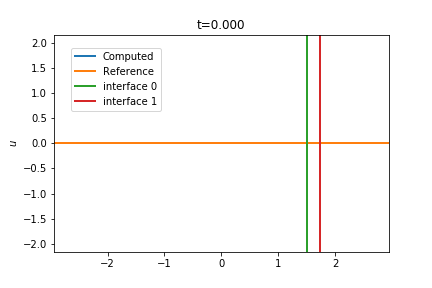
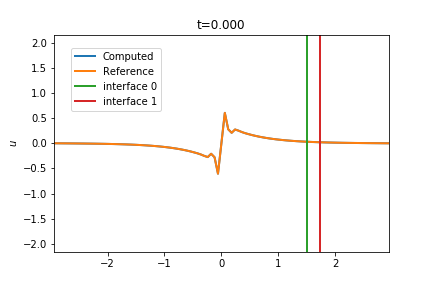
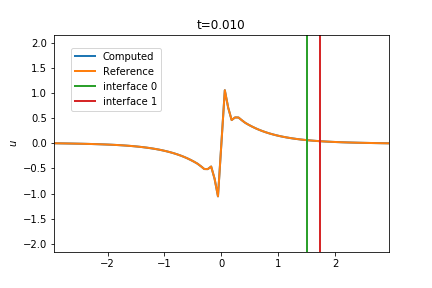
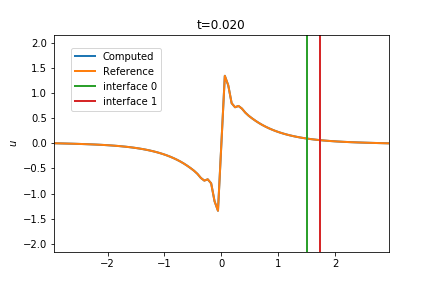
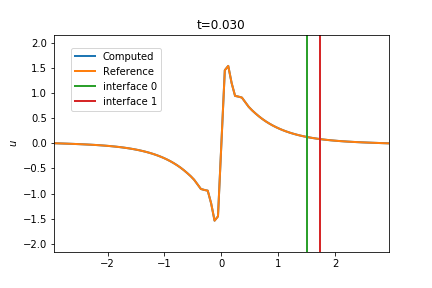
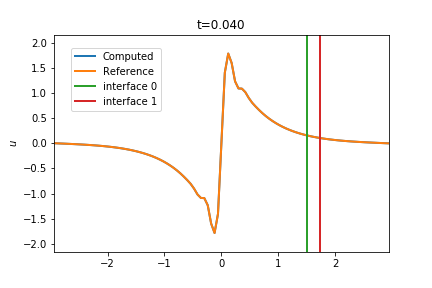
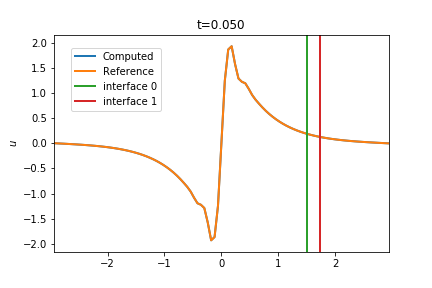
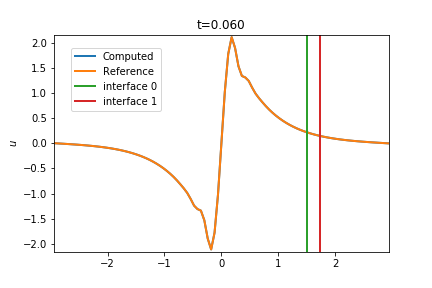
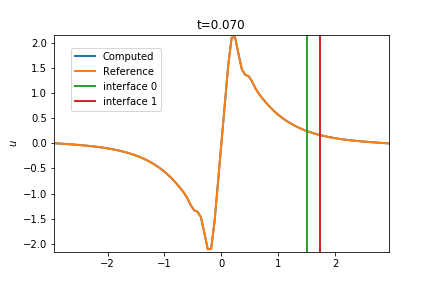
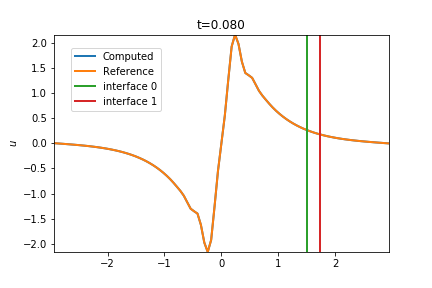
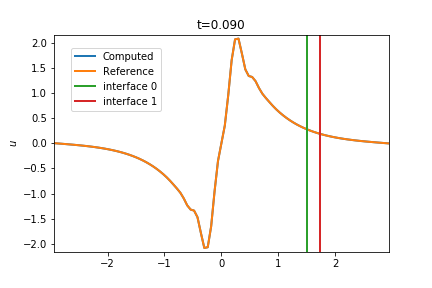
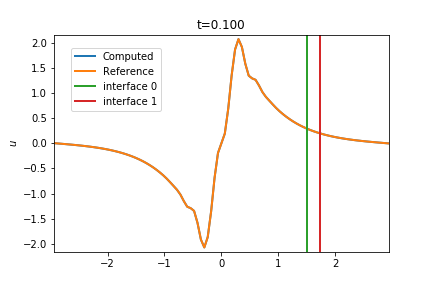
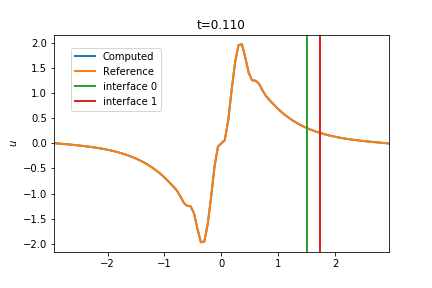
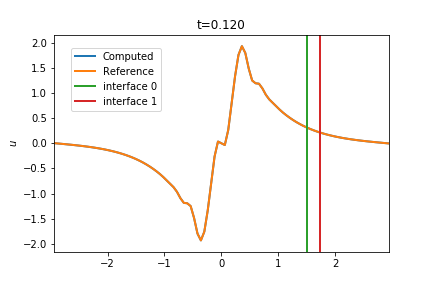
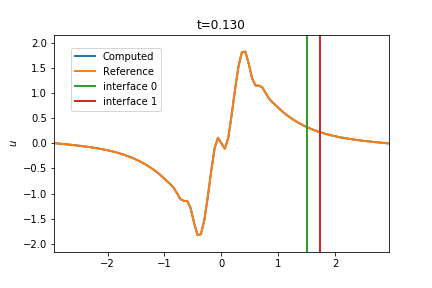
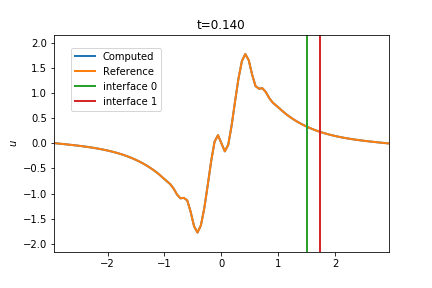
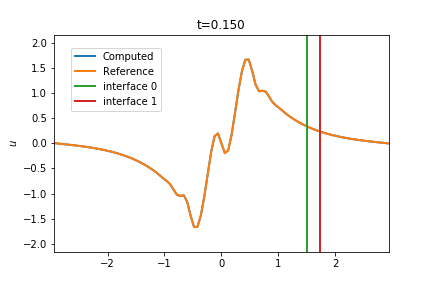
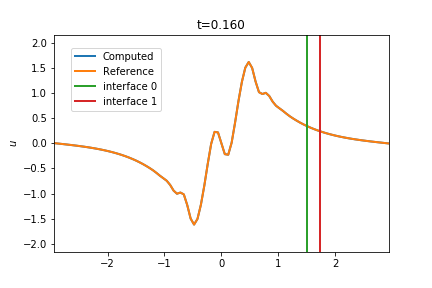
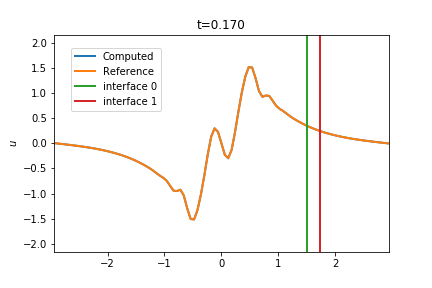
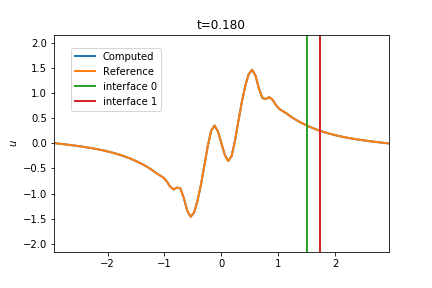
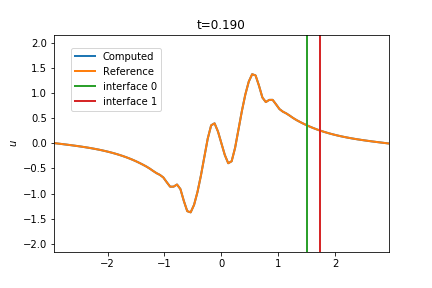
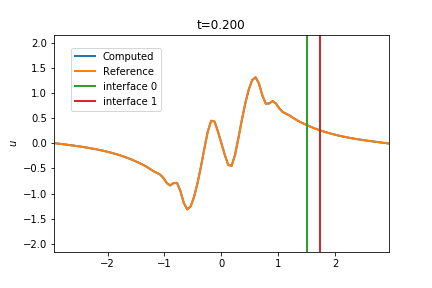
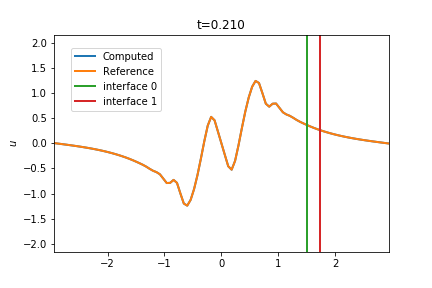
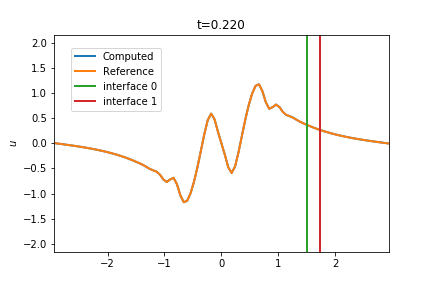
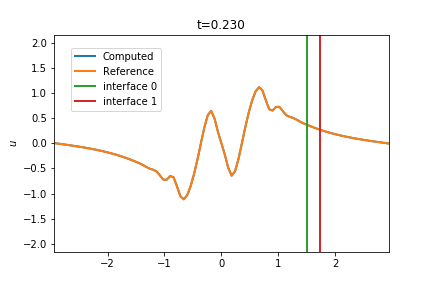
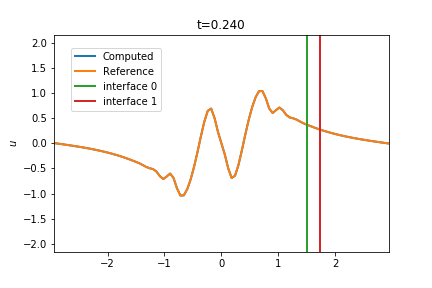
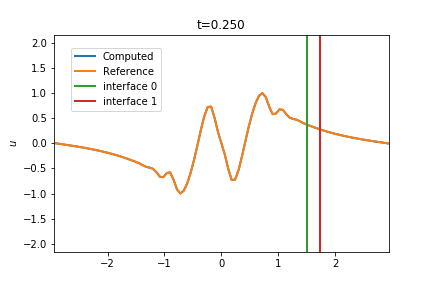
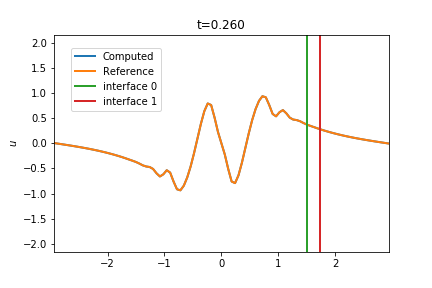
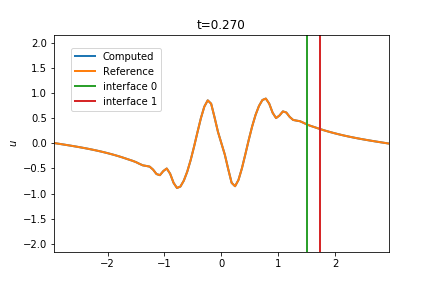
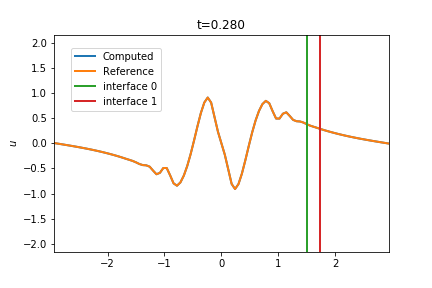
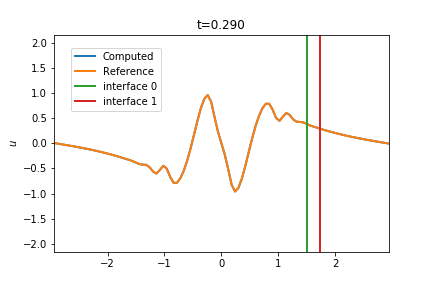
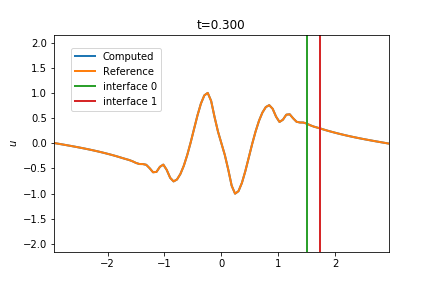
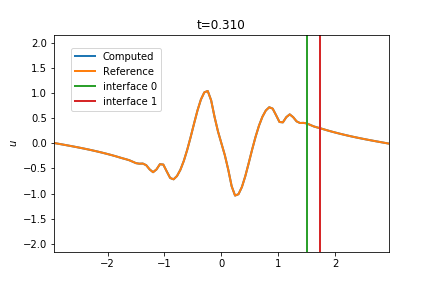
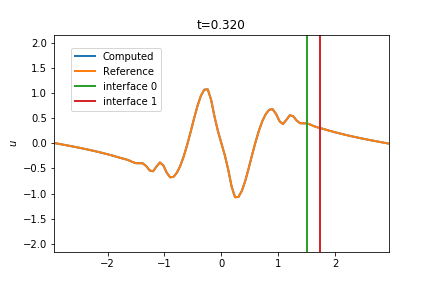
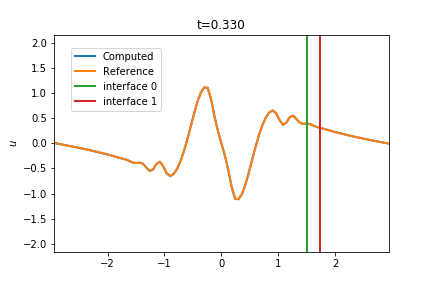
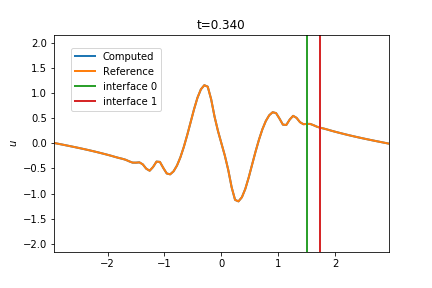
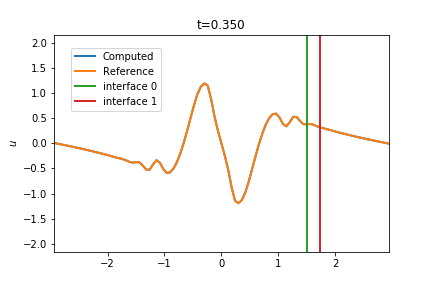
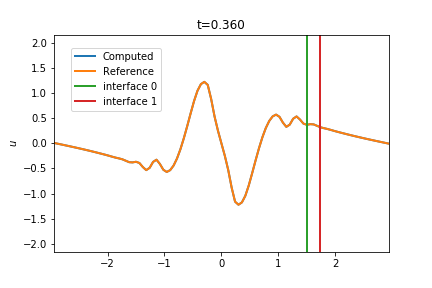
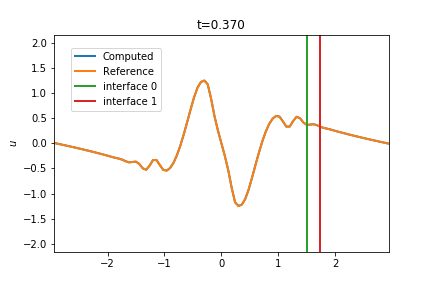
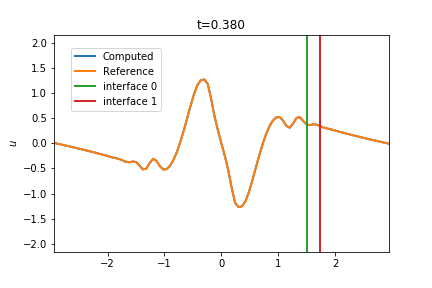
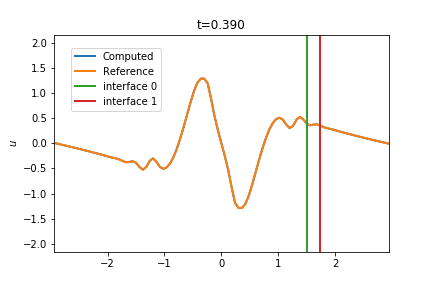
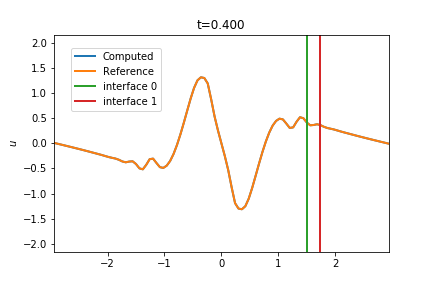
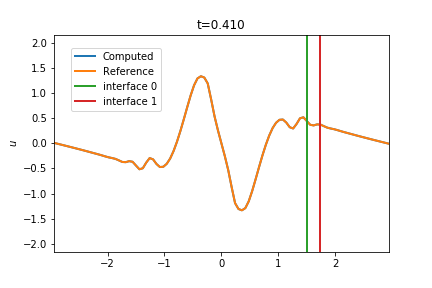
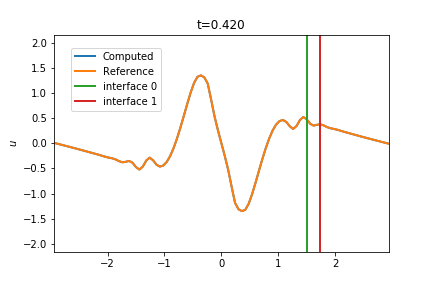
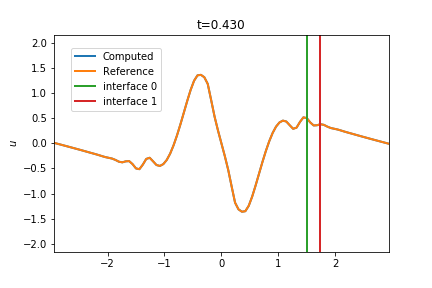
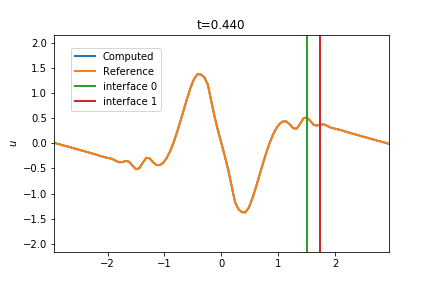
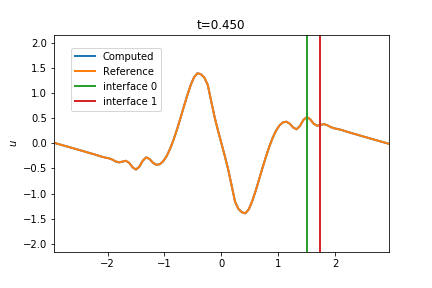
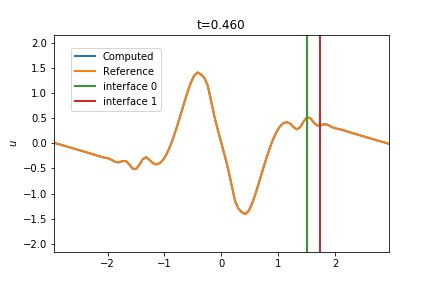
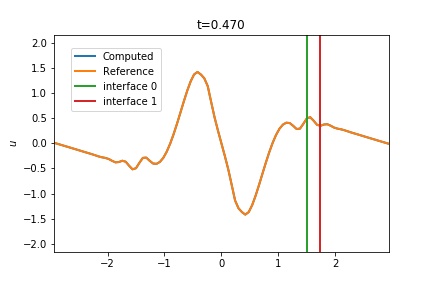
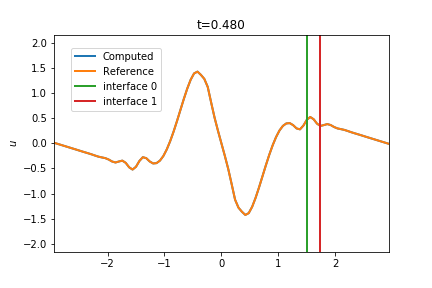
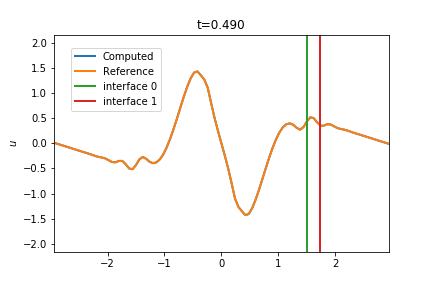
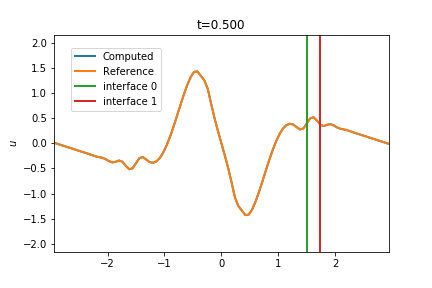
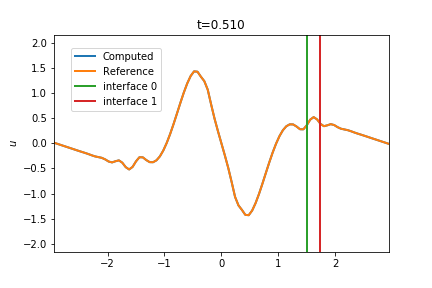
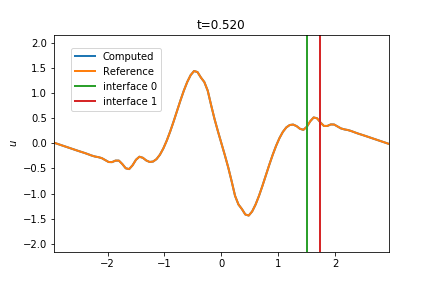
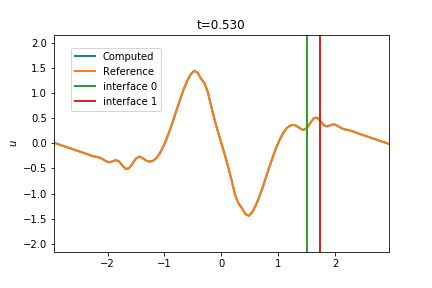
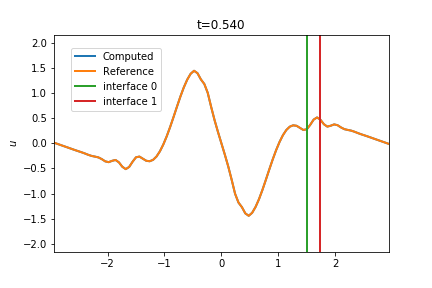
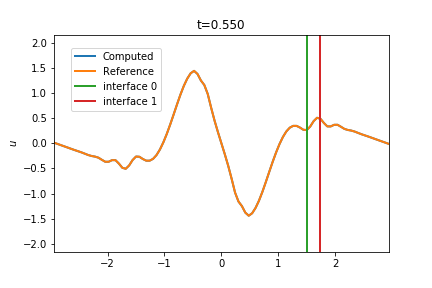
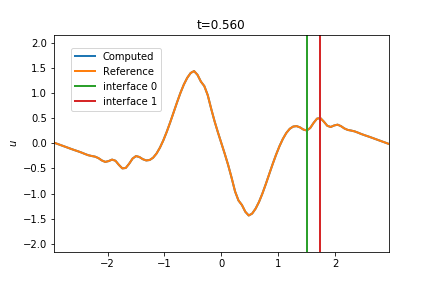
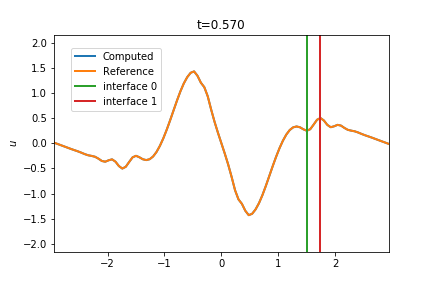
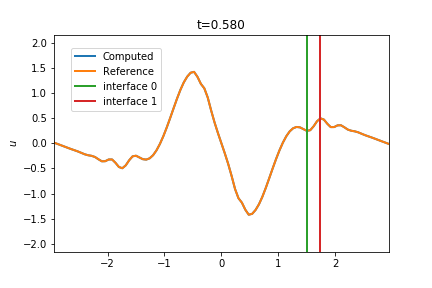
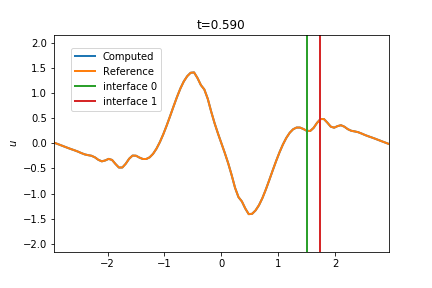
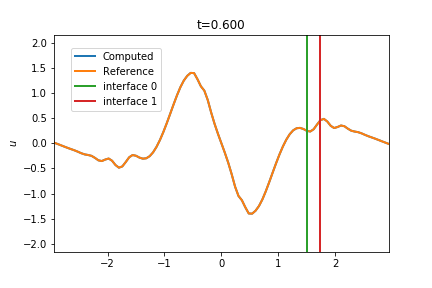
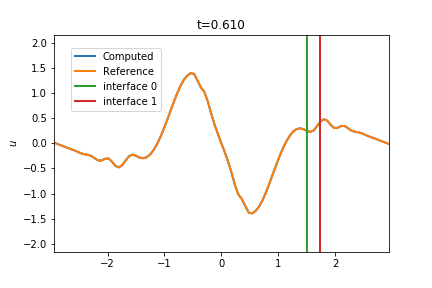
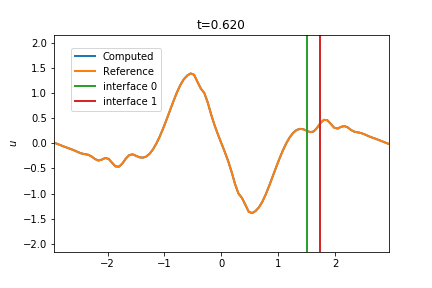
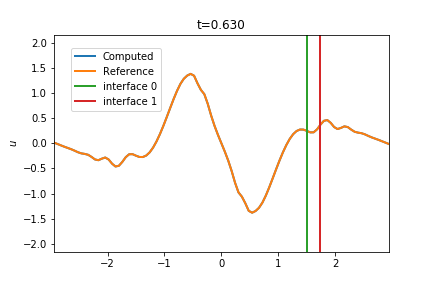
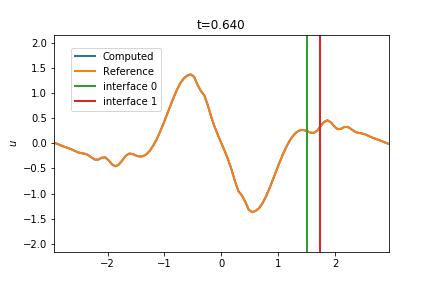
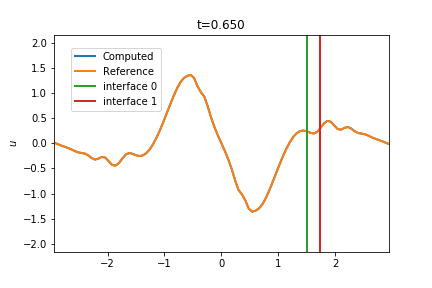
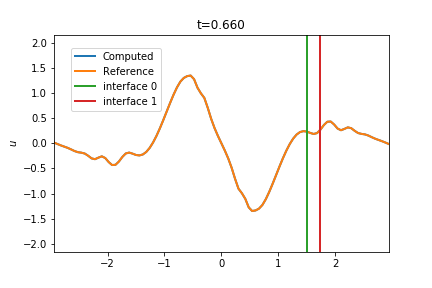
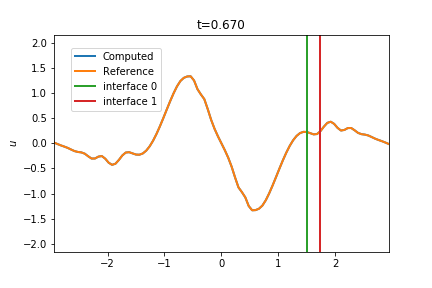
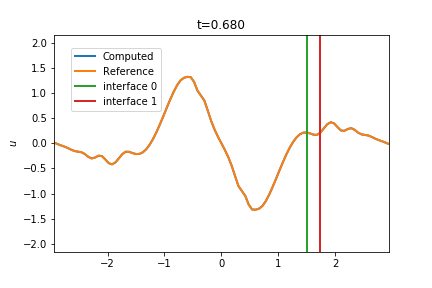
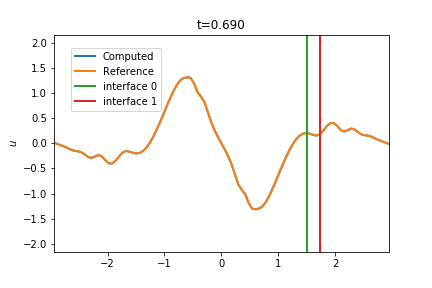
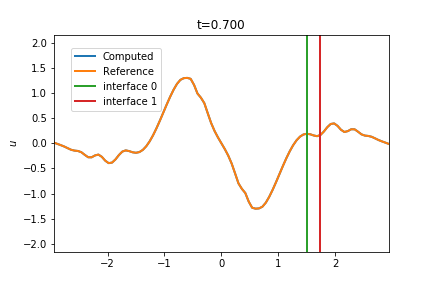
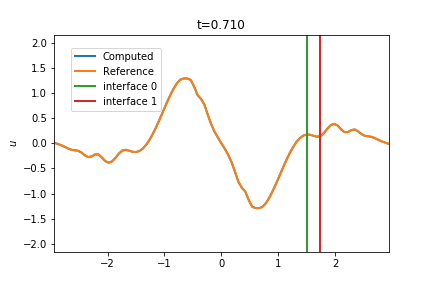
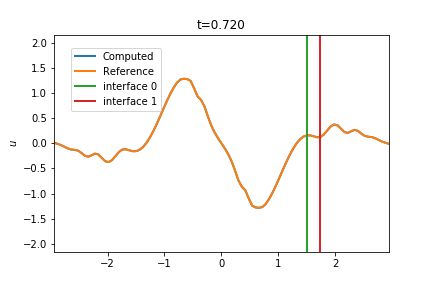
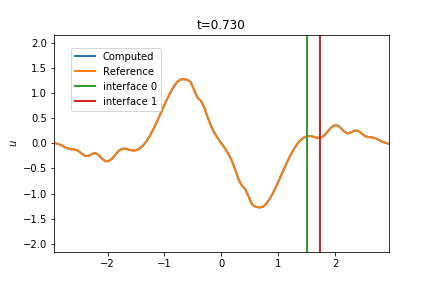
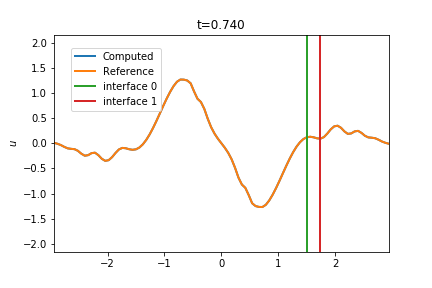
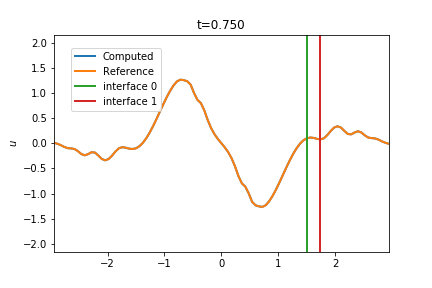
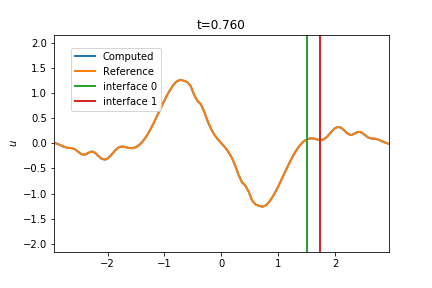
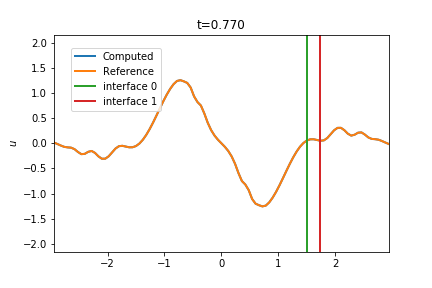
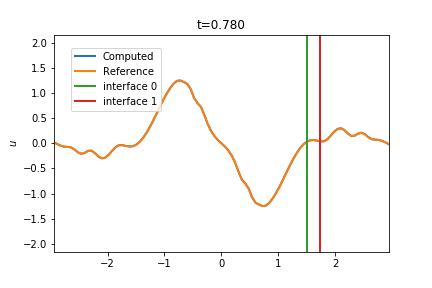
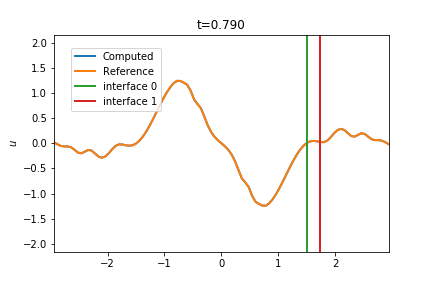
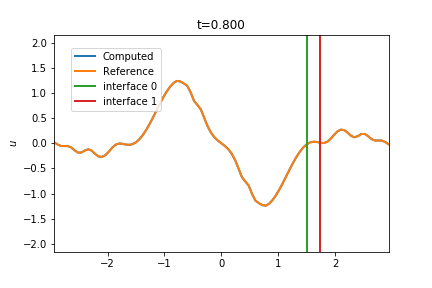
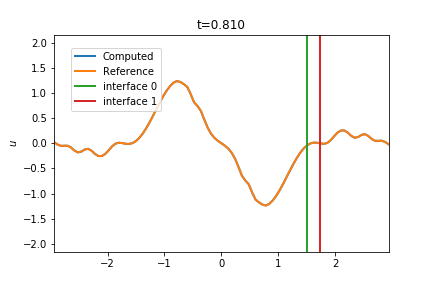
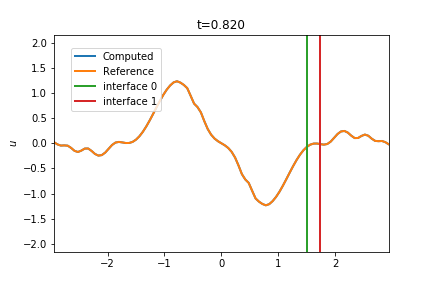
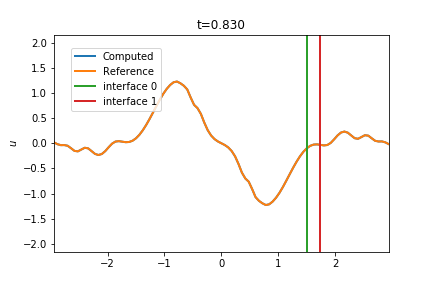
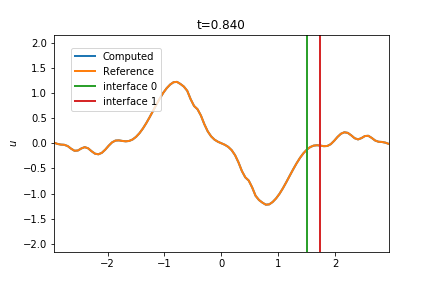
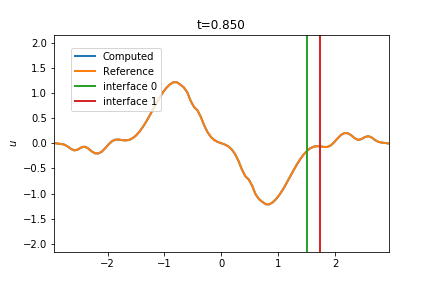
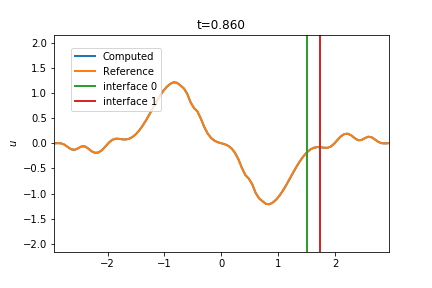
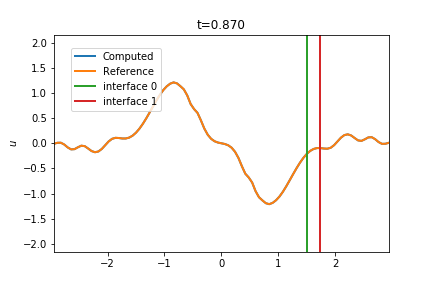
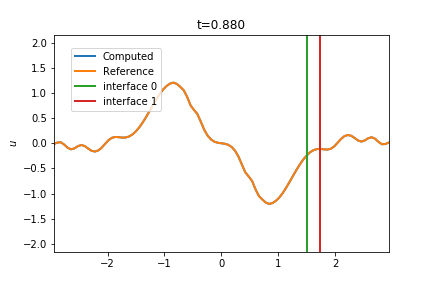
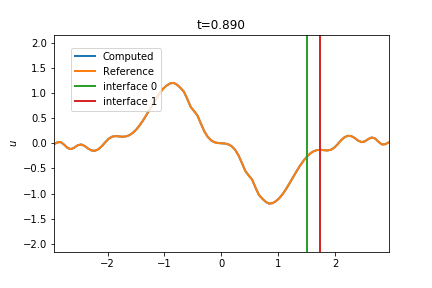
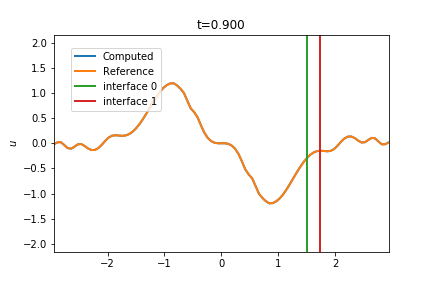
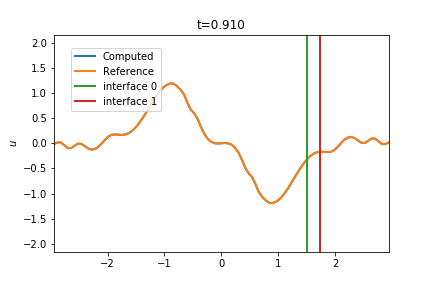
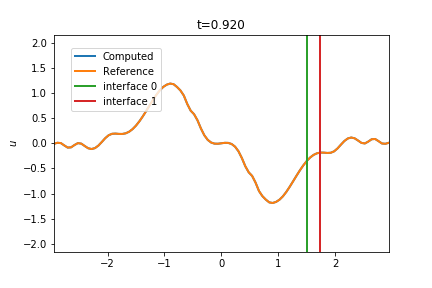
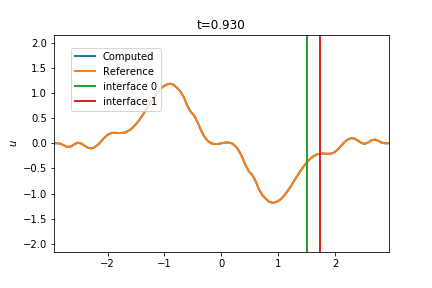
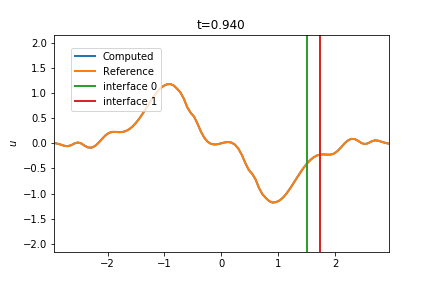
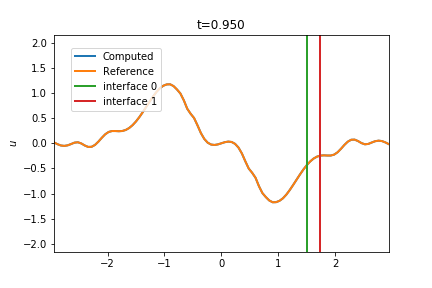
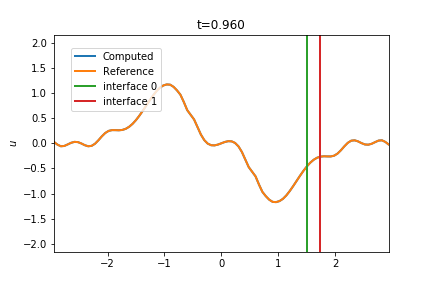
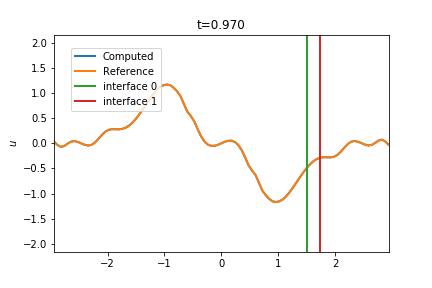
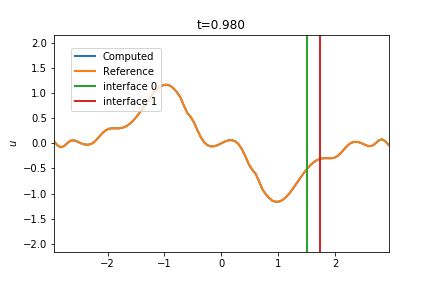
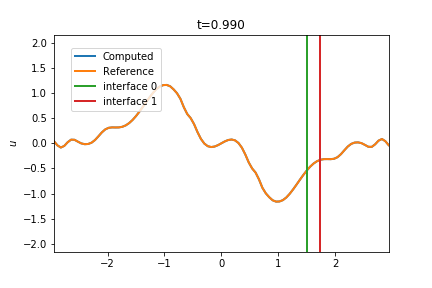
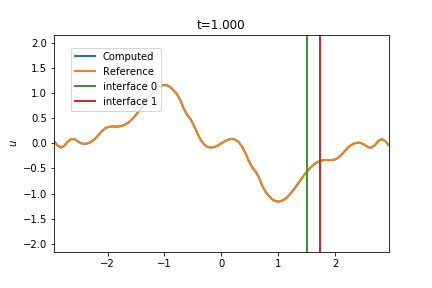
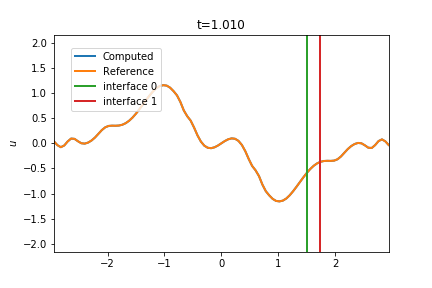
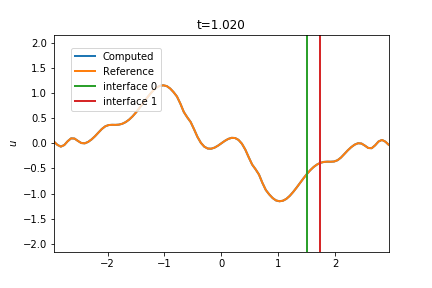
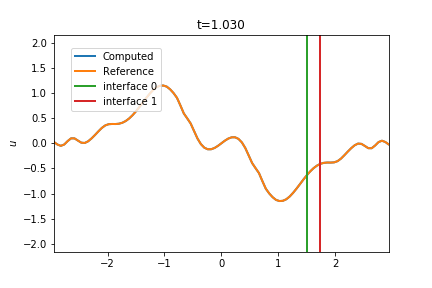
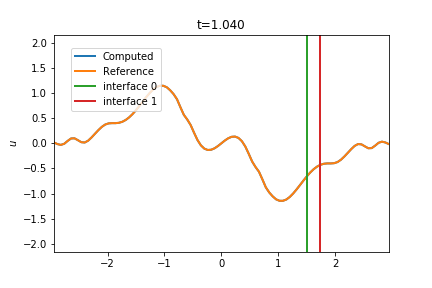
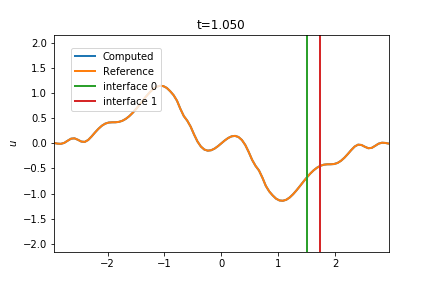
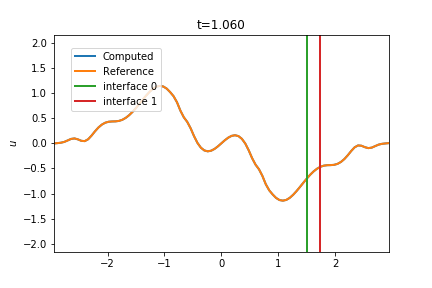
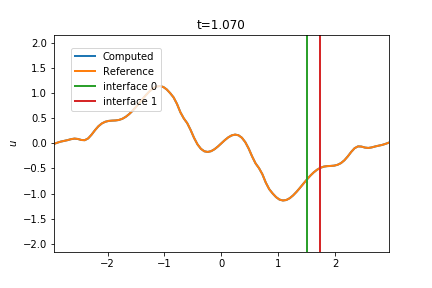
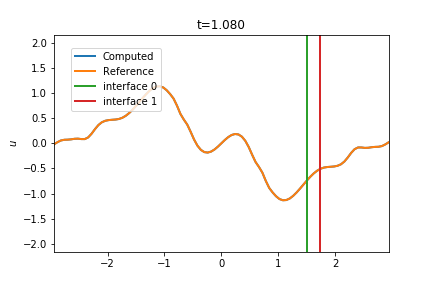
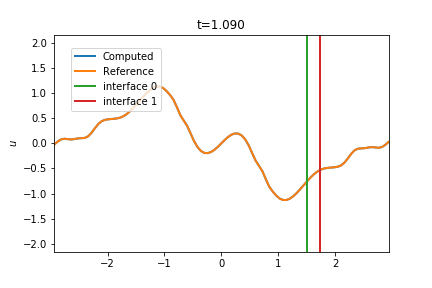
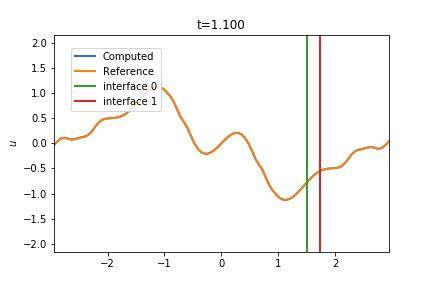
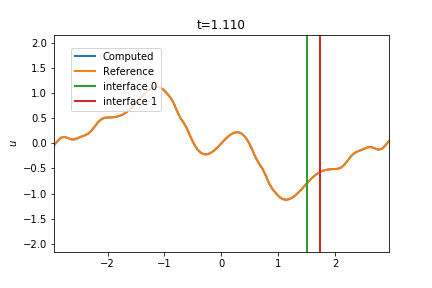
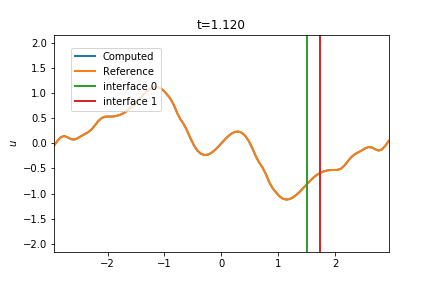
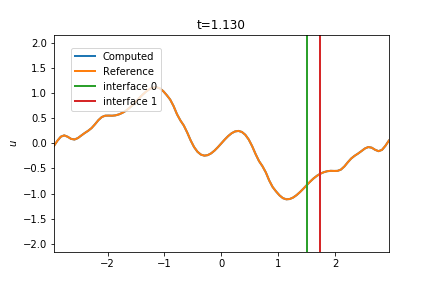
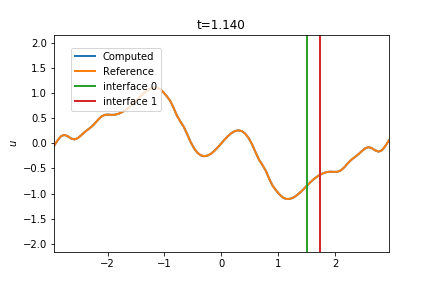
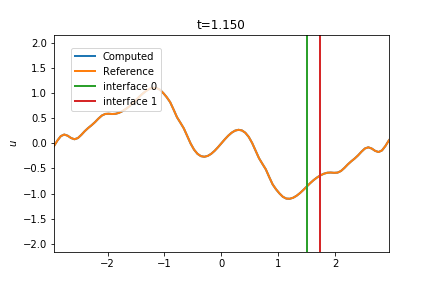
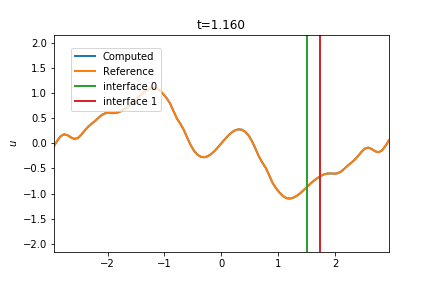
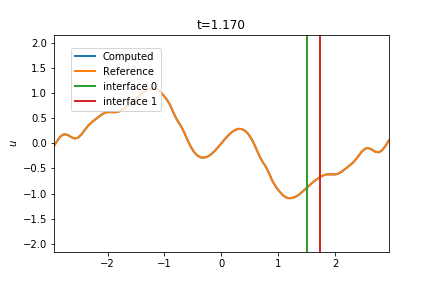
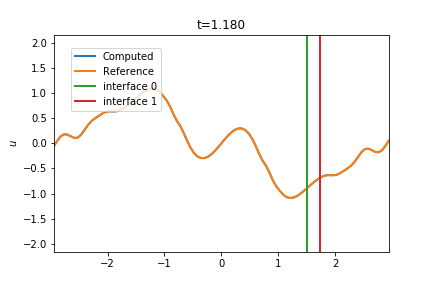
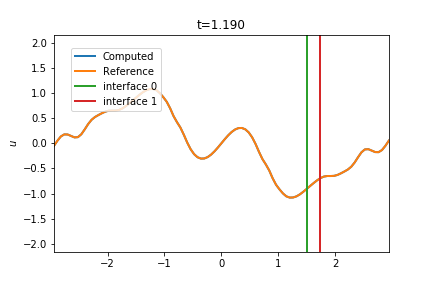
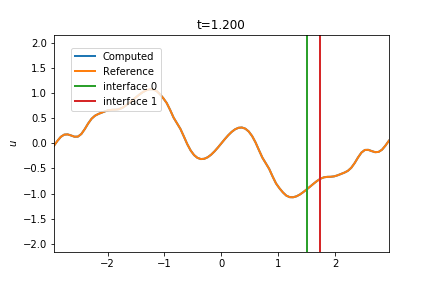
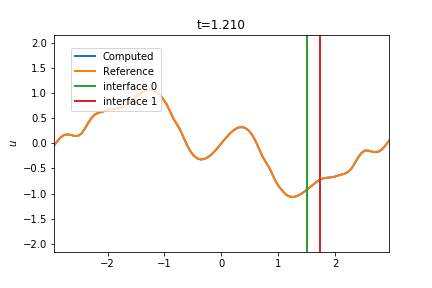
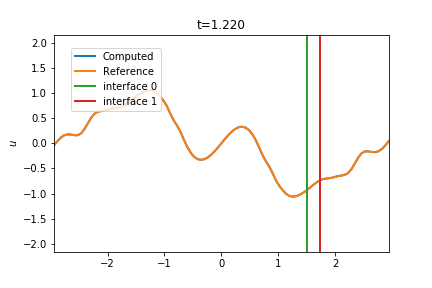
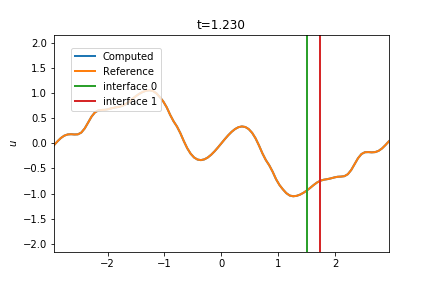
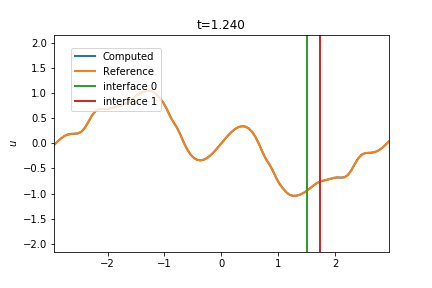
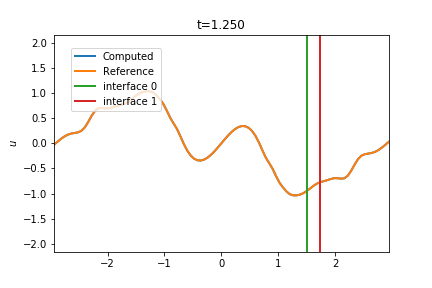
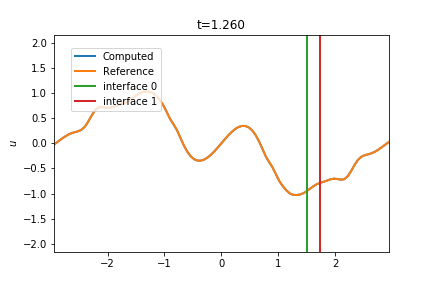
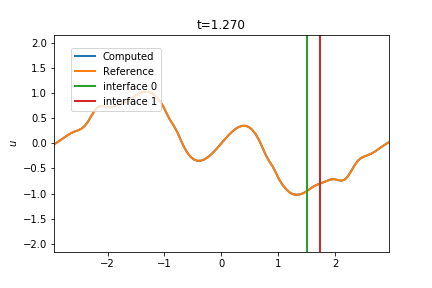
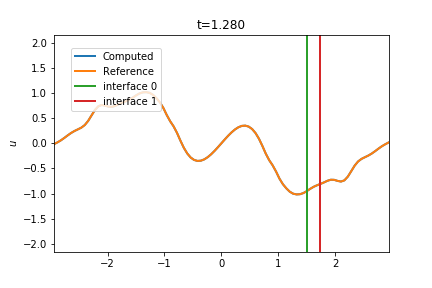
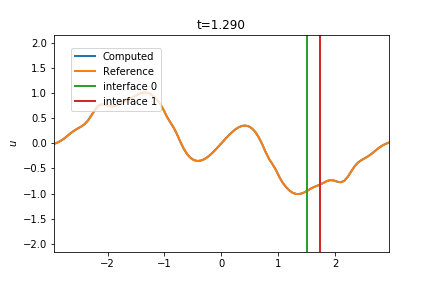
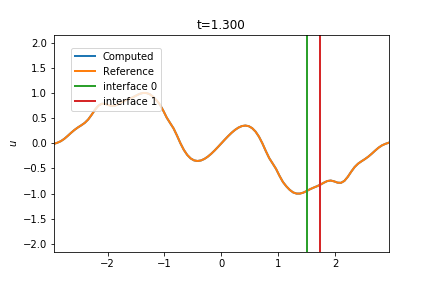
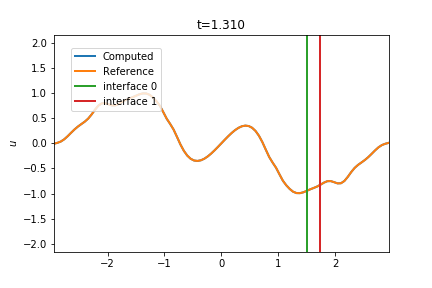
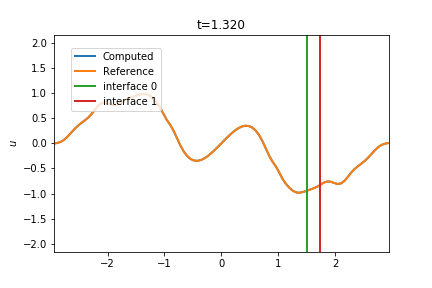
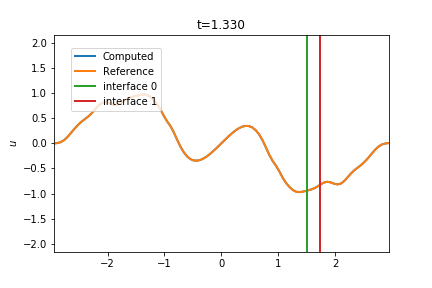
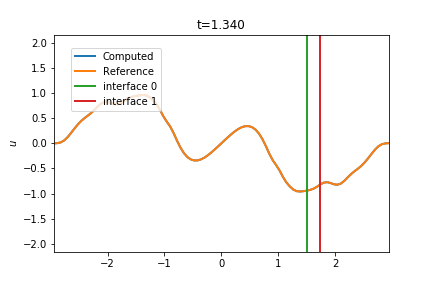
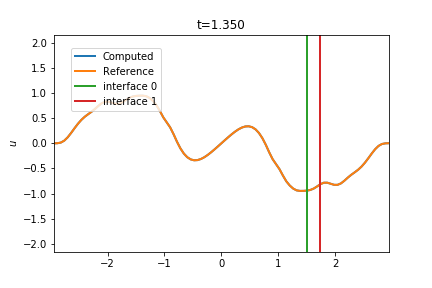
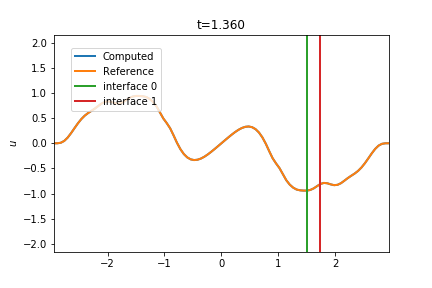
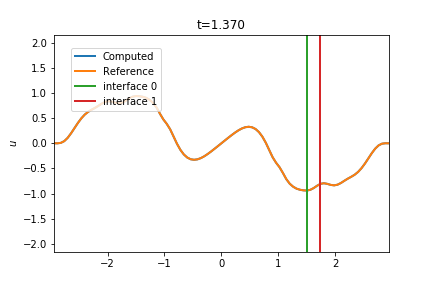
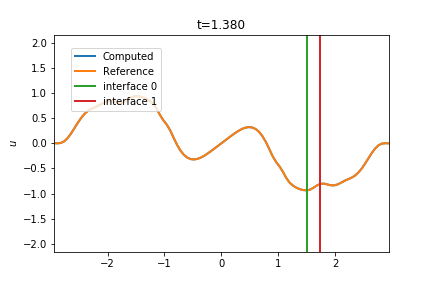
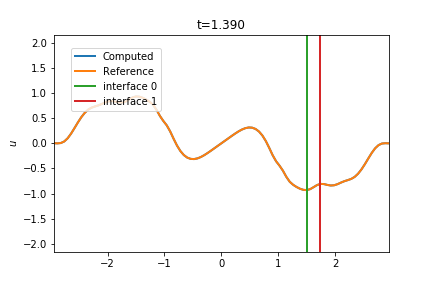
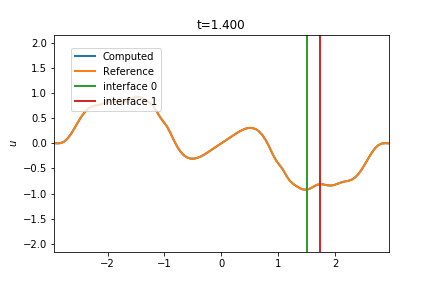
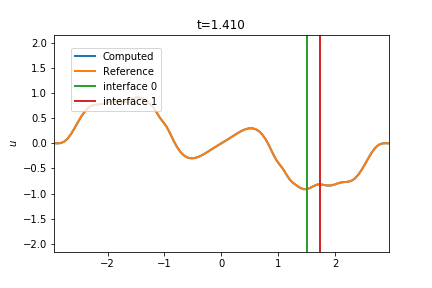
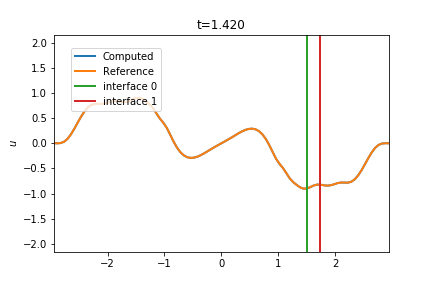
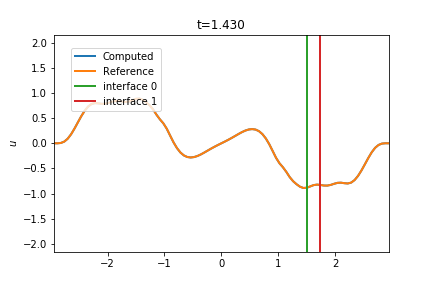
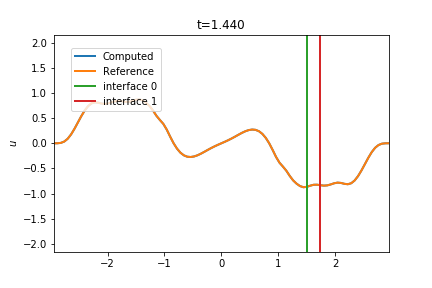
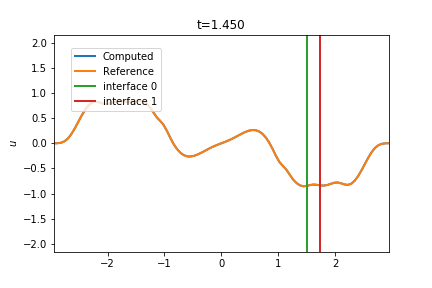
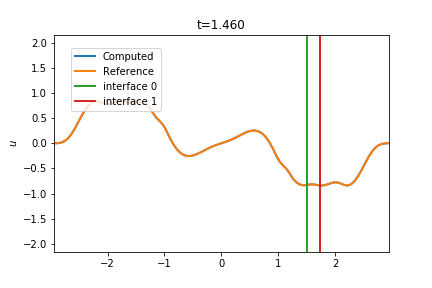
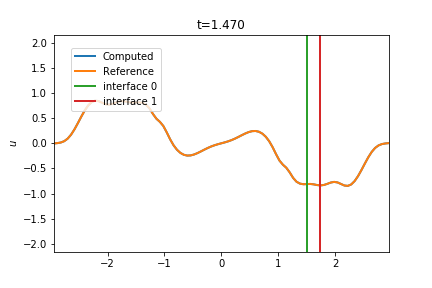
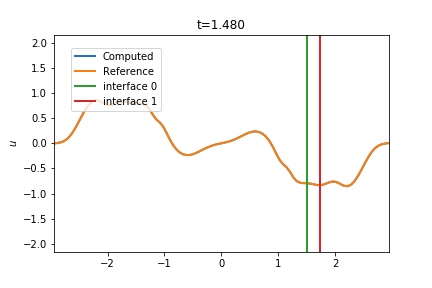
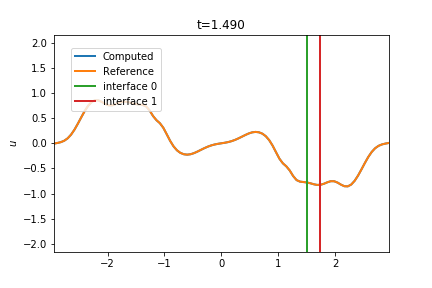
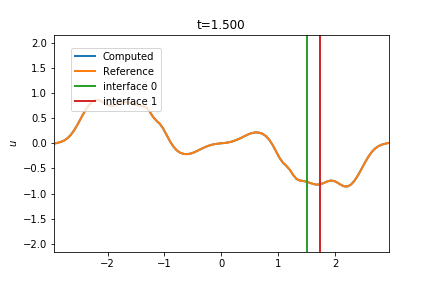
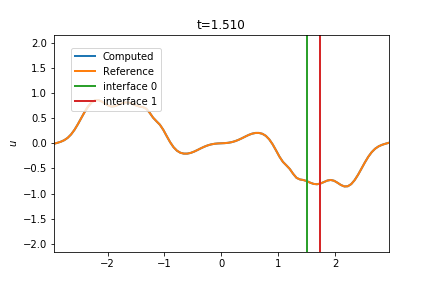
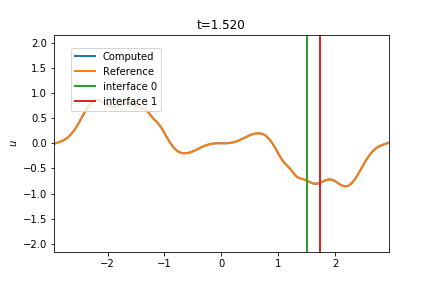
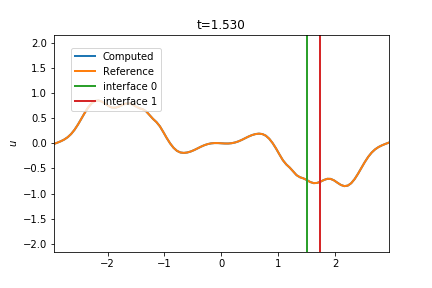
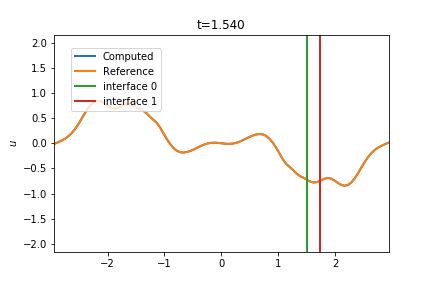
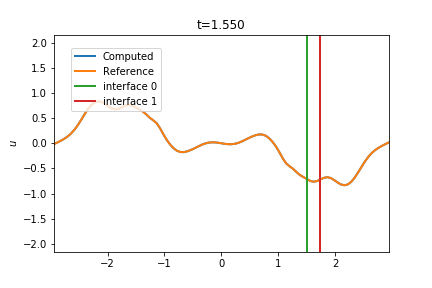
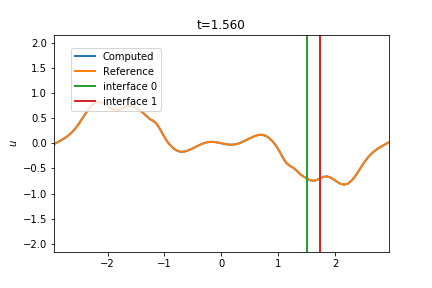
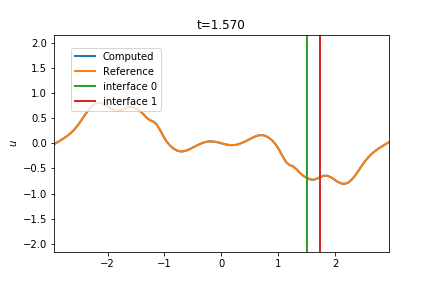
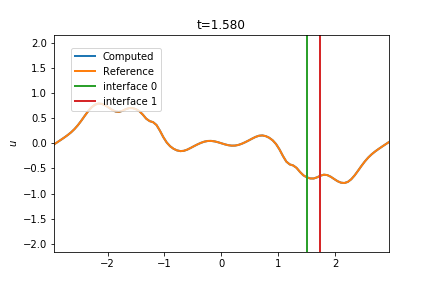
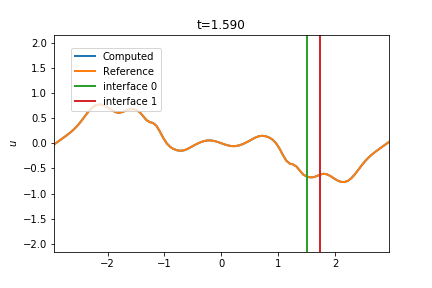
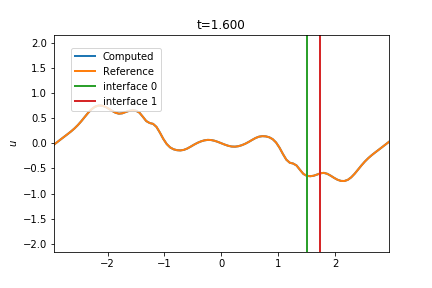
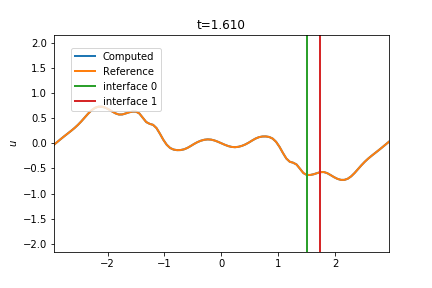
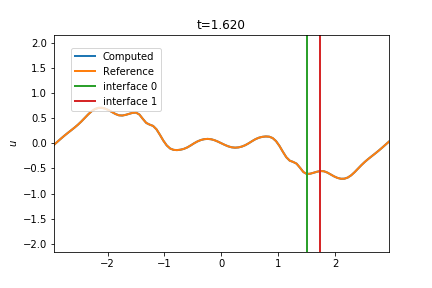
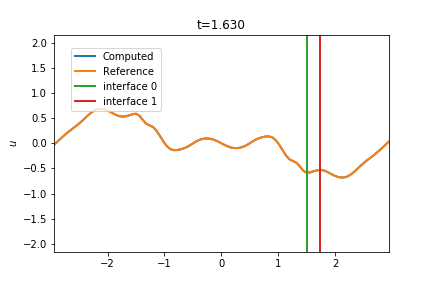
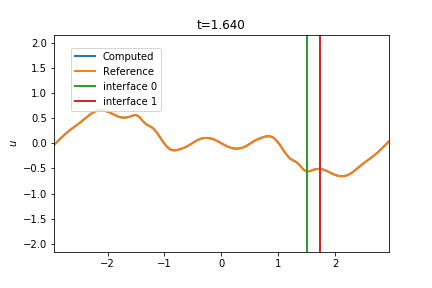
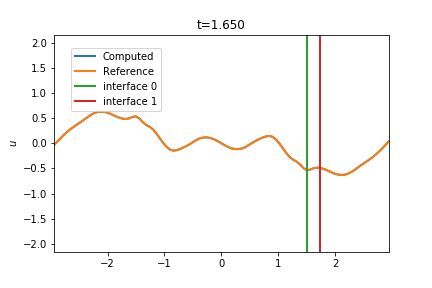
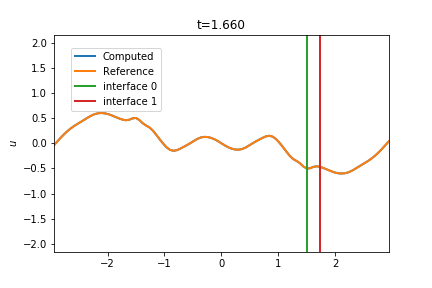
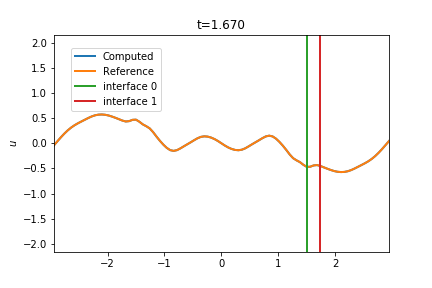
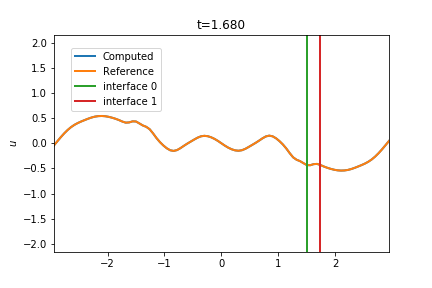
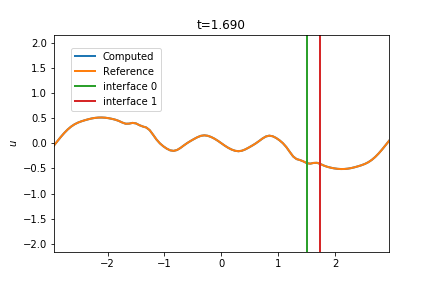
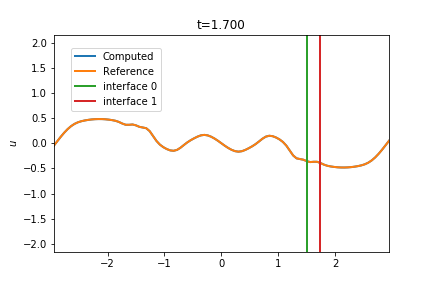
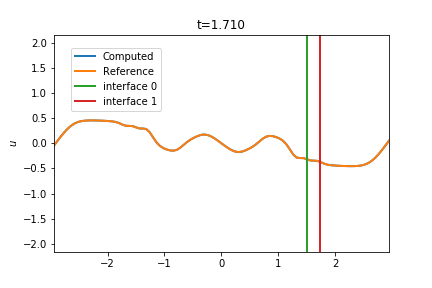
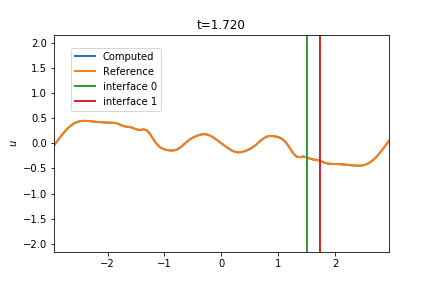
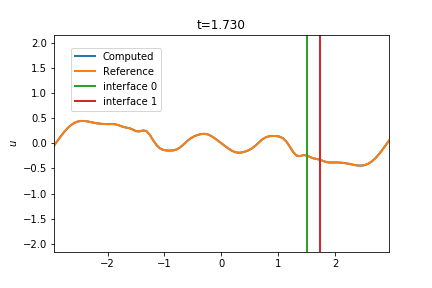
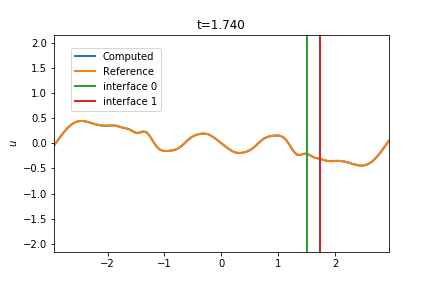
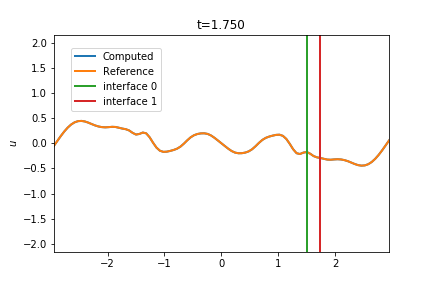
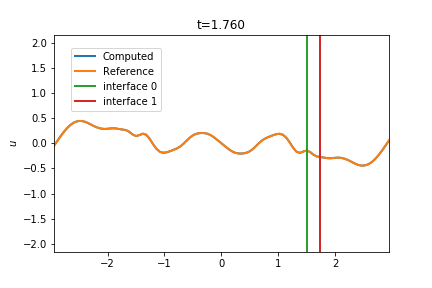
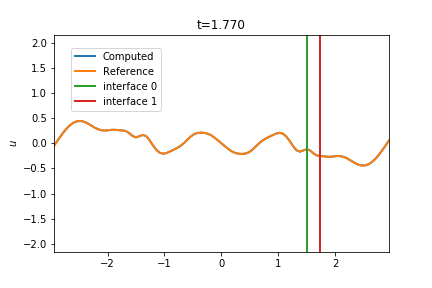
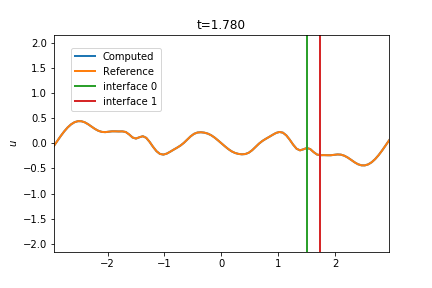
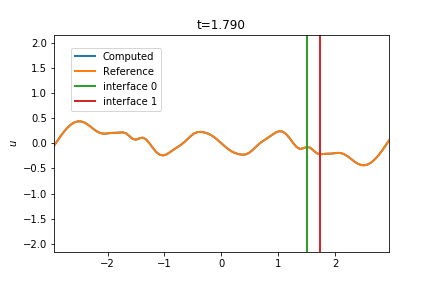
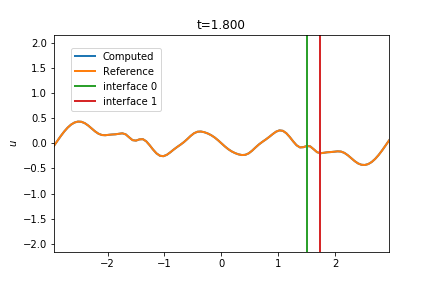
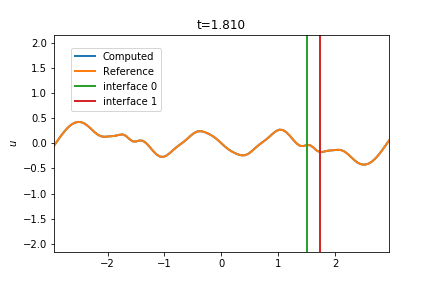
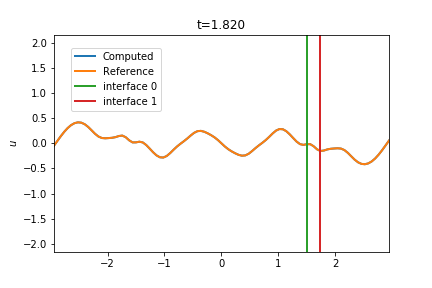
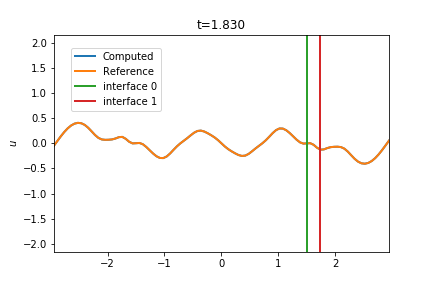
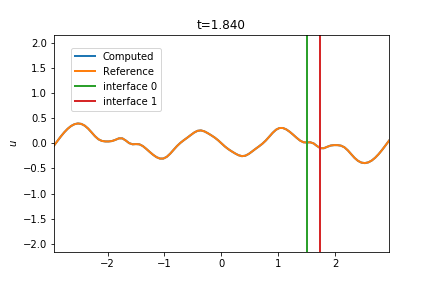
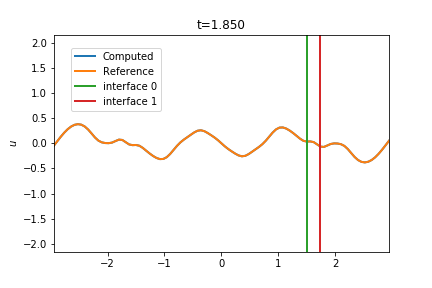
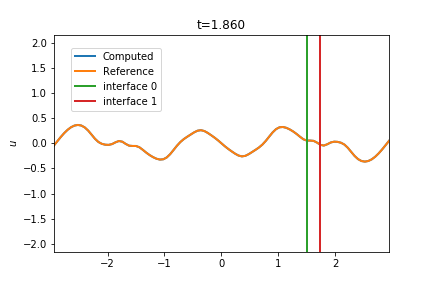
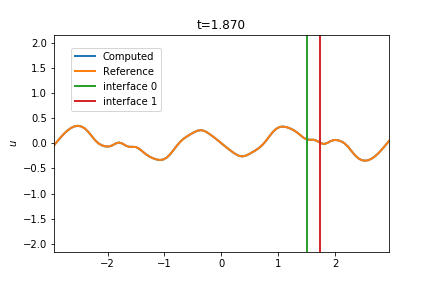
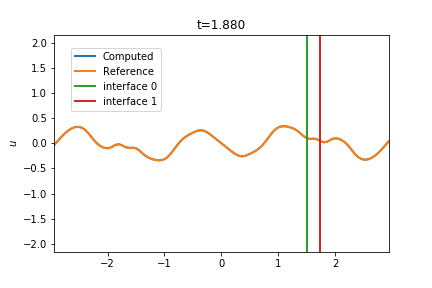
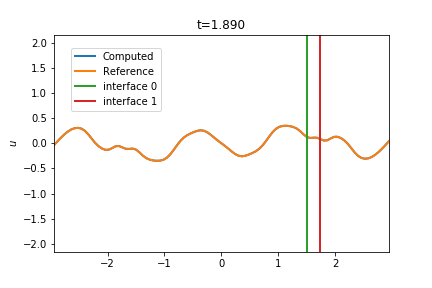
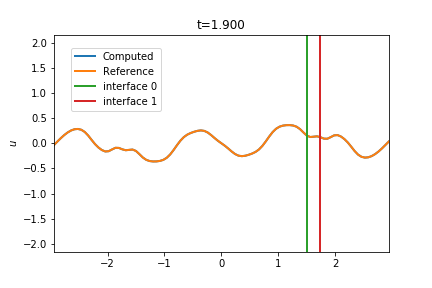
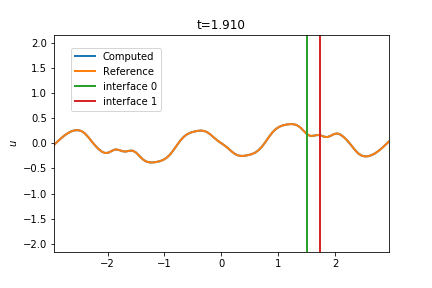
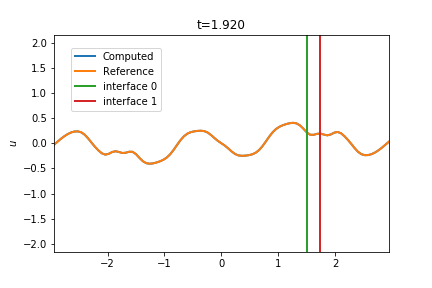
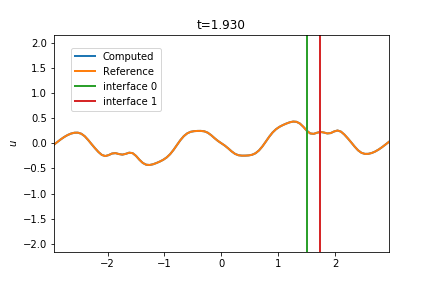
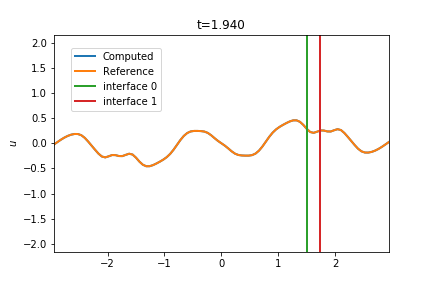
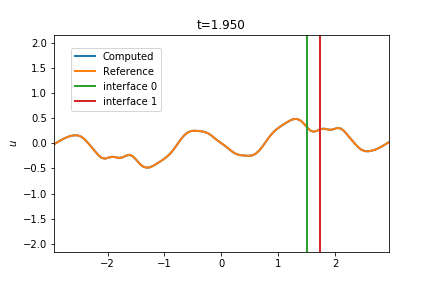
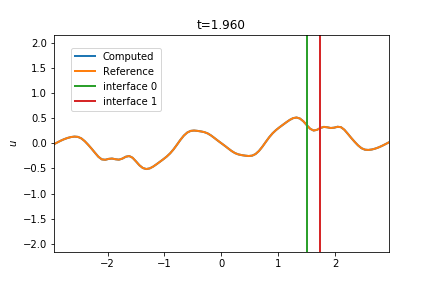
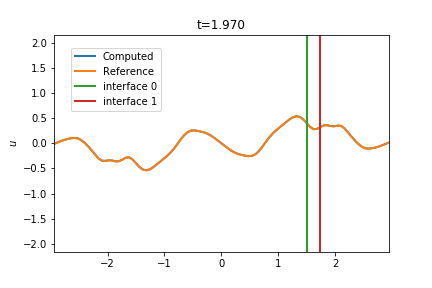
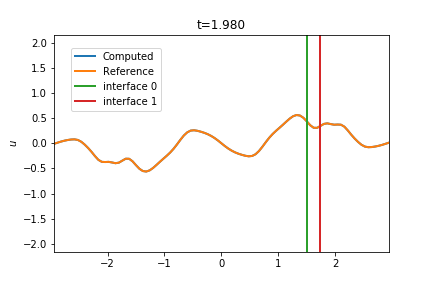
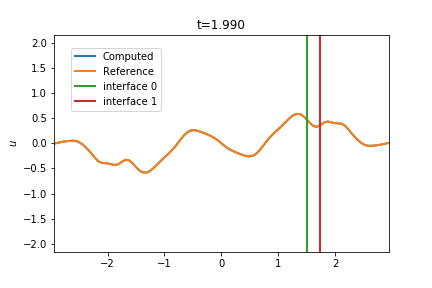

In [17]:
lb = ["Computed","Reference"]
# save = None
save = "./u_DDM_{}.mp4".format(init_cond)
gF.plotAnimationNSolutions(2,x,np.array([uall,uallref]),tall,xmin+dx,xmax-dx,umin,umax,lb,
                           ylabel=r'$u$',location=(0.05,0.65), savePath=save, ddm=ddm)